# Examen: Módulo 3

In [102]:
import numpy as np 
import pandas as pd

#Visualización
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry_convert as pc
import geopandas as gpd

#Escalamiento
from sklearn.preprocessing import StandardScaler

#Reducción de dimensionalidad
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import PCA

#Clúster
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from sklearn.neighbors import NearestNeighbors


pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('./data_fifa.csv')

## Limpieza de datos

### Valores nulos (completitud)

In [3]:
nulls = [c for c in data.columns if data[c].isnull().sum() > 0]
nulls = data[nulls].isnull().sum().sort_values(ascending=False) / data.shape[0]

In [4]:
nulls.value_counts()

0.002636    43
0.114516    26
0.003295     2
0.930576     1
0.085901     1
0.085297     1
0.015873     1
0.013237     1
Name: count, dtype: int64

In [5]:
#Variables sin información
data = data.drop(['Loaned From'], axis=1)

In [6]:
#Segundos nulls
nulls2 = nulls[(nulls > 0.11) & (nulls < 0.12)].index
for c in nulls2:
    data[c] = data[c].fillna(data[c].mode()[0])

In [7]:
# Terceros nulls
nulls3 = nulls[(nulls > 0.01) & (nulls < 0.09)].index

#Proceso auxiliar (formato de Release Clause)
data['Release Clause'] = data['Release Clause'].fillna('0')
data['Release Clause 2'] = np.where(data['Release Clause'].str.contains('M', na=False), 1000000, 1000)
data['Release Clause'] = data['Release Clause'].str.replace('€', '')
data['Release Clause'] = data['Release Clause'].str.replace('M', '')
data['Release Clause'] = data['Release Clause'].str.replace('K', '')
data['Release Clause'] = data['Release Clause'].astype(float)
data['Release Clause'] = data['Release Clause'] * data['Release Clause 2']
data['Release Clause'] = data['Release Clause'].replace(0, data['Release Clause'].median())
data = data.drop(['Release Clause 2'], axis=1)

#Proceso auxiliar (formato de Joined)
data['Joined'] = data['Joined'].fillna(data['Joined'].mode()[0])
data['Joined'] = pd.to_datetime(data['Joined'])

#Proceso auxiliar (formato de Contract Valid Until) y definición de Duration
data['Joined'] = data['Joined'].fillna(data['Joined'].mode()[0])
data['Joined'] = pd.to_datetime(data['Joined'])
data['Contract Valid Until'] = data['Contract Valid Until'].fillna(data['Contract Valid Until'].mode()[0])
for d in data['Contract Valid Until']:
    if len(d) > 4:
        data['Contract Valid Until'] = data['Contract Valid Until'].str[-4:]

data['Contract Valid Until'] = data['Contract Valid Until'].astype(int)
data['Duration'] = data['Contract Valid Until'] - data['Joined'].dt.year

#Eliminación de variables Joined y Contract Valid Until (ya no son necesarias)

data = data.drop(['Joined', 'Contract Valid Until'], axis=1)

#Rellenar el Club
data['Club'] = data['Club'].fillna(np.random.choice(data['Club'].value_counts().index[:100]))


In [8]:
#4 nulls

nulls4 = nulls[nulls < 0.01].index
nulls4n = data[nulls4].select_dtypes(include=[np.number]).columns
nulls4nn = data[nulls4].select_dtypes(exclude=[np.number]).columns
for c in nulls4n:
    data[c] = data[c].fillna(data[c].median())

for c in nulls4nn:
    data[c] = data[c].fillna(data[c].mode()[0])

In [9]:
#Definición de variables numéricas y no numéricas 1

varnum = data.select_dtypes(include=[np.number]).columns
varnonum = data.select_dtypes(exclude=[np.number]).columns

In [10]:
#Estandarización de variables con calificación de 0 a 100

data['International Reputation'] = data['International Reputation'] * 100 / 5
data['Weak Foot'] = data['Weak Foot'] * 100 / 5
data['Skill Moves'] = data['Skill Moves'] * 100 / 5

In [11]:
#Formato de value y Wage

#Value
data['Value 2'] = np.where(data['Value'].str.contains('M', na=False), 1000000, 1000)
data['Value'] = data['Value'].str.replace('€', '')
data['Value'] = data['Value'].str.replace('M', '')
data['Value'] = data['Value'].str.replace('K', '')

data['Value'] = data['Value'].astype(float)

data['Value'] = data['Value'] * data['Value 2']

data = data.drop(['Value 2'], axis=1)

#Wage
data['Wage 2'] = np.where(data['Wage'].str.contains('M', na=False), 1000000, 1000)
data['Wage'] = data['Wage'].str.replace('€', '')
data['Wage'] = data['Wage'].str.replace('M', '')
data['Wage'] = data['Wage'].str.replace('K', '')

data['Wage'] = data['Wage'].astype(float)

data['Wage'] = data['Wage'] * data['Wage 2']

data = data.drop(['Wage 2'], axis=1)

data[['Value', 'Wage']] = data[['Value', 'Wage']].replace(0, data[['Value', 'Wage']].quantile(0.4))

In [12]:
#Normalización del pie preferido, Work Rate, Body Type y Position

#Pie preferido
data['Preferred Foot'] = data['Preferred Foot'].map({'Right': 1, 'Left': 0})

#Work Rate
data[['WR1', 'WR2']] = data['Work Rate'].str.split('/ ', expand=True)
data[['WR1', 'WR2']] = data[['WR1', 'WR2']].replace(['Low', 'Medium', 'High'], [1, 2, 3])
data['Work Rate 2'] = (data['WR1'] + data['WR2']) / 2
data['Work Rate 2'] = (data['Work Rate 2'] - data['Work Rate 2'].min()) / (data['Work Rate 2'].max() - data['Work Rate 2'].min()) * 100
data['Work Rate'] = data['Work Rate 2']

data = data.drop(['WR1', 'WR2', 'Work Rate 2'], axis=1)


#Body Type
data['Body Type'] = data['Body Type'].replace(['Messi', 'C. Ronaldo', 'Neymar', 'Courtois', 'PLAYER_BODY_TYPE_25', 'Shaqiri', 'Akinfenwa'], 'Normal')

#Posiciones

forwards = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW']
midfiel = ['LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM']
defend = ['LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']
goal = ['GK']

data['Position'] = data['Position'].replace(forwards, 'Forward')
data['Position'] = data['Position'].replace(midfiel, 'Midfielder')
data['Position'] = data['Position'].replace(defend, 'Defender')
data['Position'] = data['Position'].replace(goal, 'Goalkeeper')


#Formato Height y Weight

data['Height'] = data['Height'].str.replace("'", '.')
data['Height'] = data['Height'].astype(float)
data['Height'] = data['Height'] * 30.48

data['Weight'] = data['Weight'].str.replace('lbs', '')
data['Weight'] = data['Weight'].astype(float)
data['Weight'] = data['Weight'] * 0.453592

#Variables que no son relevantes
data = data.drop(['Jersey Number', 'Photo', 'Flag', 'Club Logo', 'Real Face'], axis=1)

In [13]:
#Definición de variables numéricas y no numéricas 2

varnum = data.select_dtypes(include=[np.number]).columns
varnonum = data.select_dtypes(exclude=[np.number]).columns

In [14]:
data[varnonum]

Name Nationality                 Club Body Type  \
0                L. Messi   Argentina         FC Barcelona    Normal   
1       Cristiano Ronaldo    Portugal             Juventus    Normal   
2               Neymar Jr      Brazil  Paris Saint-Germain    Normal   
3                  De Gea       Spain    Manchester United      Lean   
4            K. De Bruyne     Belgium      Manchester City    Normal   
...                   ...         ...                  ...       ...   
18202        J. Lundstram     England      Crewe Alexandra      Lean   
18203  N. Christoffersson      Sweden       Trelleborgs FF    Normal   
18204           B. Worman     England     Cambridge United    Normal   
18205      D. Walker-Rice     England      Tranmere Rovers      Lean   
18206           G. Nugent     England      Tranmere Rovers      Lean   

         Position  
0         Forward  
1         Forward  
2         Forward  
3      Goalkeeper  
4      Midfielder  
...           ...  
18202  Midfielder  
18203     Forward  
18204     Forward  
18205     Forward  
18206  Midfielder  

[18207 rows x 5 columns]

## Duplicados

In [15]:
#Identificación de duplicados
dups = data[data.duplicated('Name', keep=False)]

#Prueba (se conserva el mas reciente)
dups = dups.sort_values('Age', ascending=False).drop_duplicates('Name', keep='first')

#Eliminación de duplicados
data = data.sort_values('Age', ascending=False).drop_duplicates('Name', keep='first')
data = data.reset_index(drop=True)
data = data.drop(['Name'], axis=1)

In [16]:
data

ID  Age        Nationality  Overall  Potential  \
0      140029   45             Mexico       71         71   
1       53748   44            England       48         48   
2       51963   44  Trinidad & Tobago       53         53   
3      140183   42              Japan       65         65   
4      142998   41          Argentina       68         68   
...       ...  ...                ...      ...        ...   
17189  246601   16            England       51         66   
17190  246009   16          Australia       52         69   
17191  245015   16        Netherlands       59         75   
17192  242165   16             Norway       52         67   
17193  246269   16            England       46         66   

                               Club     Value    Wage  Special  \
0                           Pachuca  160000.0  8000.0     1256   
1                  Cambridge United  525000.0  1000.0      774   
2                Accrington Stanley  525000.0  1000.0      926   
3                    Nagoya Grampus   40000.0  1000.0     1296   
4      CD Universidad de Concepción   60000.0  1000.0     1234   
...                             ...       ...     ...      ...   
17189                    Shrewsbury   70000.0  1000.0     1334   
17190                     Sydney FC  100000.0  1000.0     1420   
17191                     VVV-Venlo  300000.0  1000.0     1442   
17192                 FK Bodø/Glimt  100000.0  1000.0     1457   
17193               Tranmere Rovers   60000.0  1000.0     1321   

       Preferred Foot  International Reputation  Weak Foot  Skill Moves  \
0                   1                      40.0       60.0         20.0   
1                   1                      20.0       40.0         20.0   
2                   1                      20.0       40.0         20.0   
3                   1                      40.0       60.0         20.0   
4                   1                      20.0       60.0         20.0   
...               ...                       ...        ...          ...   
17189               1                      20.0       60.0         40.0   
17190               0                      20.0       60.0         40.0   
17191               1                      20.0       40.0         60.0   
17192               1                      20.0       40.0         40.0   
17193               1                      20.0       60.0         40.0   

       Work Rate Body Type    Position    Height     Weight    LS    ST    RS  \
0           50.0    Stocky  Goalkeeper  176.7840  74.842680  61.0  61.0  61.0   
1           50.0    Normal  Goalkeeper  188.9760  86.182480  61.0  61.0  61.0   
2           50.0    Normal  Goalkeeper  195.0720  83.914520  61.0  61.0  61.0   
3           50.0    Normal  Goalkeeper  188.9760  79.832192  61.0  61.0  61.0   
4           50.0    Normal  Goalkeeper  155.4480  73.028312  61.0  61.0  61.0   
...          ...       ...         ...       ...        ...   ...   ...   ...   
17189       50.0      Lean  Midfielder  167.6400  64.863656  46.0  46.0  46.0   
17190       50.0    Normal  Midfielder  173.7360  67.131616  48.0  48.0  48.0   
17191       50.0      Lean     Forward  155.7528  69.853168  58.0  58.0  58.0   
17192       50.0    Normal  Midfielder  179.8320  69.853168  49.0  49.0  49.0   
17193       50.0      Lean  Midfielder  155.4480  79.832192  43.0  43.0  43.0   

         LW    LF    CF    RF    RW   LAM   CAM   RAM    LM   LCM    CM   RCM  \
0      63.0  61.0  61.0  61.0  63.0  61.0  61.0  61.0  61.0  58.0  58.0  58.0   
1      63.0  61.0  61.0  61.0  63.0  61.0  61.0  61.0  61.0  58.0  58.0  58.0   
2      63.0  61.0  61.0  61.0  63.0  61.0  61.0  61.0  61.0  58.0  58.0  58.0   
3      63.0  61.0  61.0  61.0  63.0  61.0  61.0  61.0  61.0  58.0  58.0  58.0   
4      63.0  61.0  61.0  61.0  63.0  61.0  61.0  61.0  61.0  58.0  58.0  58.0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
17189  50.0  49.0  49.0  49.0  50.0  50.0  5

## Ingeniería de Variables

In [17]:
varnum = data.select_dtypes(include=[np.number]).columns
varnonum = data.select_dtypes(exclude=[np.number]).columns

In [18]:
len(varnum), len(varnonum)

(76, 4)

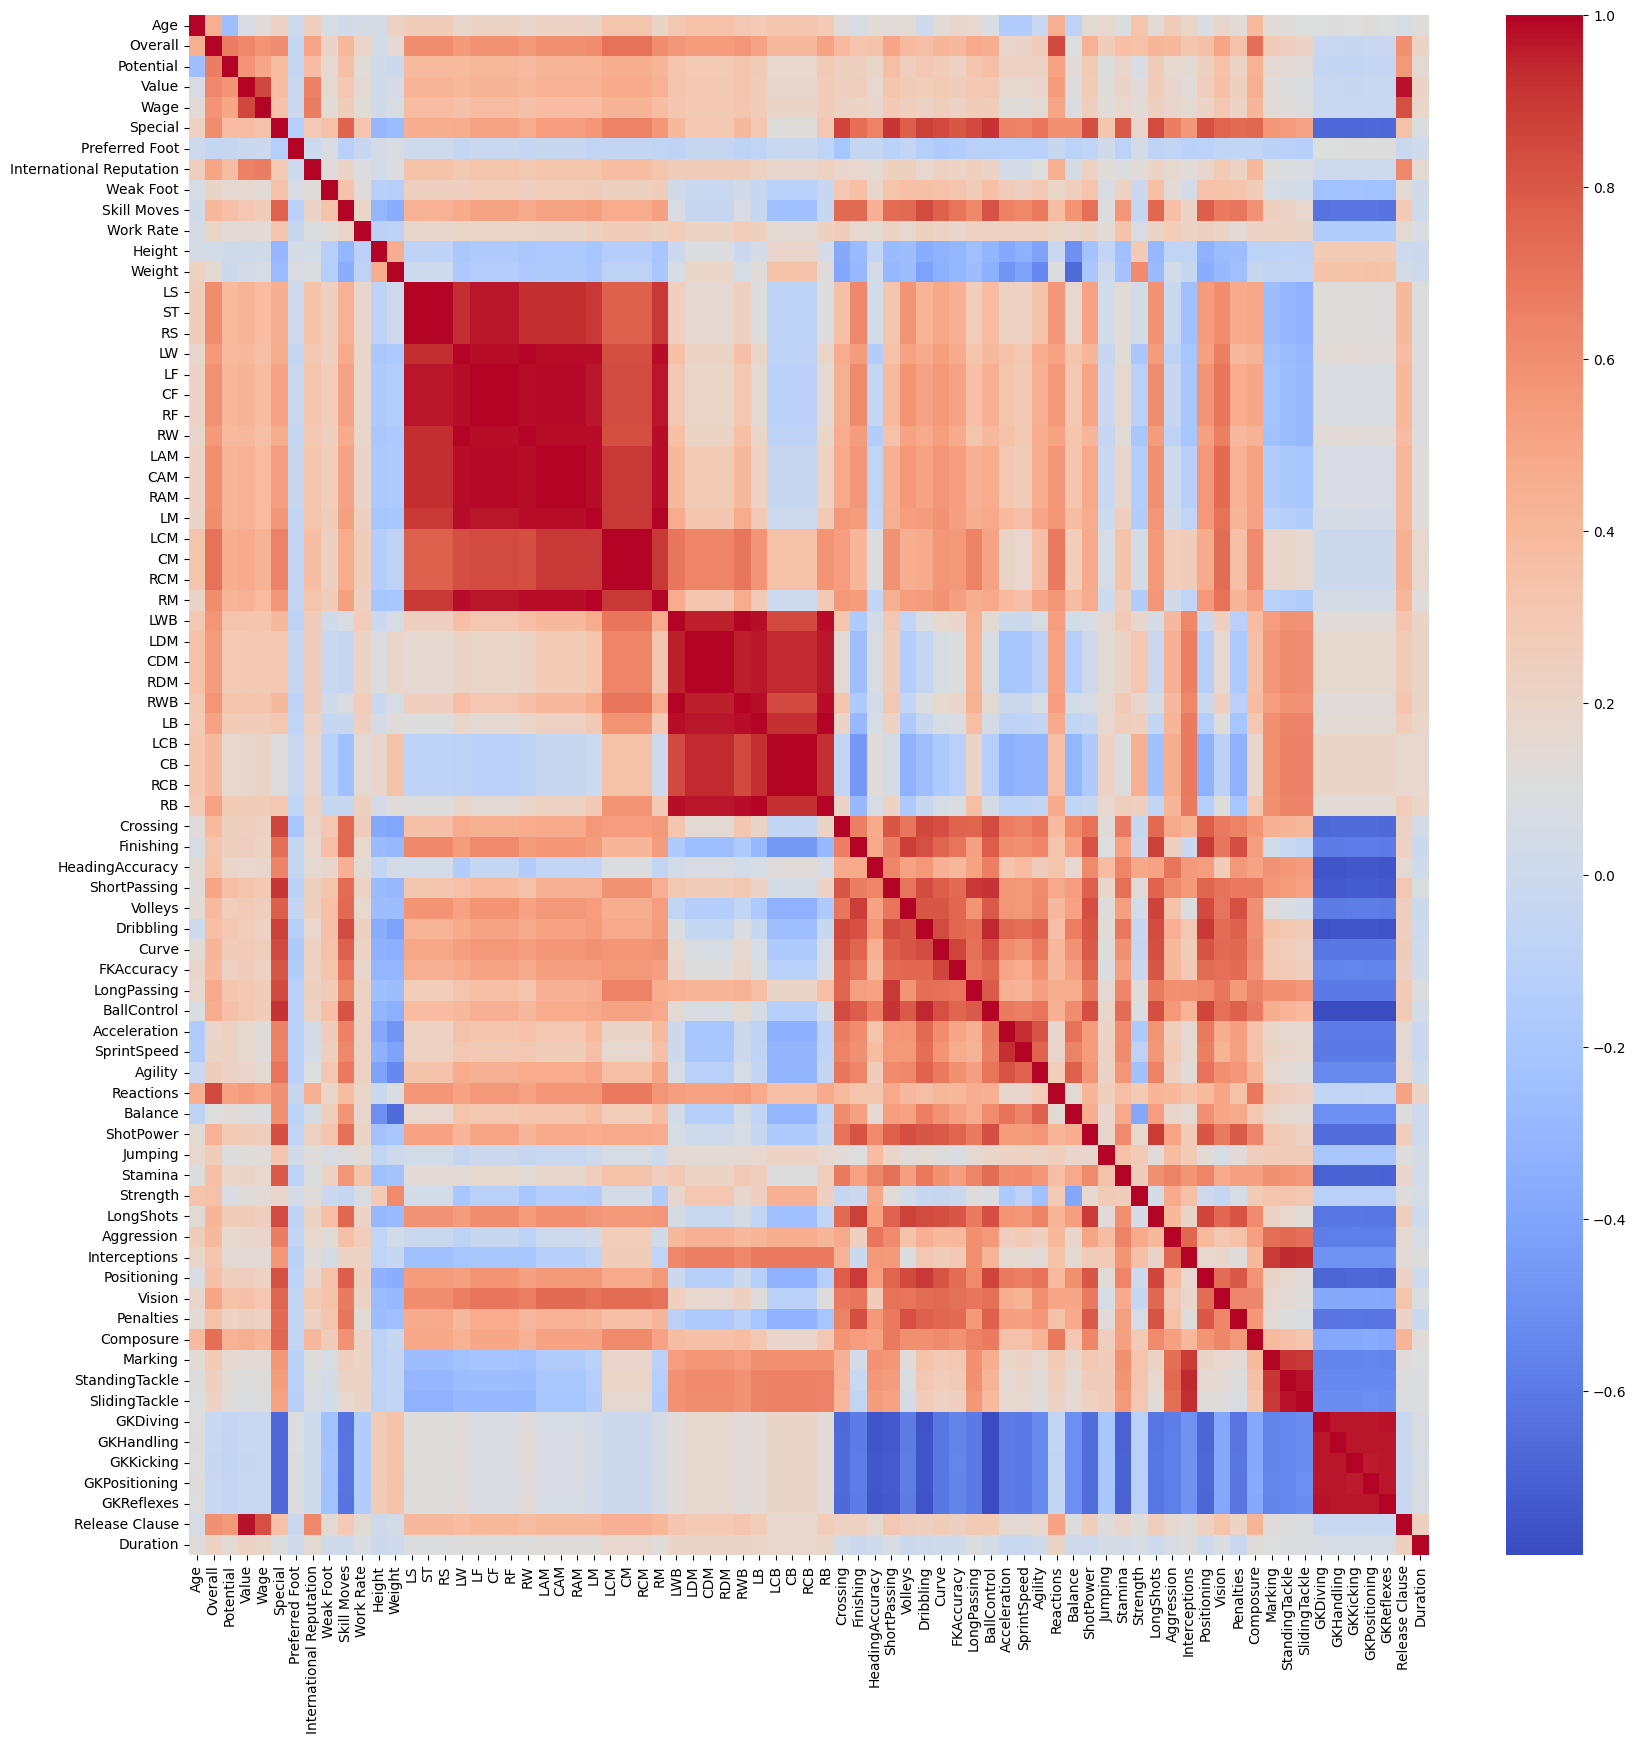

In [19]:
#Correlación de las variables numéricas

cor = data[varnum].drop('ID', axis=1).corr()

plt.figure(figsize=(20, 20))
sns.heatmap(cor, cmap='coolwarm')
plt.show()

Se puede apreciar una enorme correlación en cuanto a los scores que tienen los jugadores en las posiciones, por lo que se dará tratamiento a estas para evitar la redundancia debido a los valores altos de correlación en el "cuadro rojo" que se forma en las posiciones.

In [20]:
threshold = 0.7
cor2 = cor[((cor > threshold) | (cor < -threshold)) & (cor != 1)]
cor2 = cor2.stack().reset_index()

cor2[cor2[0] != 1]

level_0        level_1         0
0           Overall            LCM  0.712084
1           Overall             CM  0.712084
2           Overall            RCM  0.712084
3           Overall      Reactions  0.849164
4           Overall      Composure  0.726312
..              ...            ...       ...
627      GKReflexes     GKHandling  0.970639
628      GKReflexes      GKKicking  0.966761
629      GKReflexes  GKPositioning  0.970451
630  Release Clause          Value  0.974446
631  Release Clause           Wage  0.831253

[632 rows x 3 columns]

In [21]:
# Definciión de variables de ataque y defensa

defense = [
    "LWB", "LDM", "CDM", "RDM", "RWB",  
    "LB", "LCB", "CB", "RCB", "RB"      
]
attack = [
    "LS", "ST", "RS",                   
    "LW", "LF", "CF", "RF", "RW",       
    "LAM", "CAM", "RAM",                
    "LM", "LCM", "CM", "RCM", "RM"      
]

len(defense), len(attack)

(10, 16)

In [22]:
GK = ["GKDiving", "GKHandling", "GKKicking", "GKPositioning", "GKReflexes"]

In [23]:
data['Defense Score'] = data[defense].median(axis=1)
data['Attack Score'] = data[attack].median(axis=1)
data['GK Score'] = data[GK].mean(axis=1)

In [24]:
data

ID  Age        Nationality  Overall  Potential  \
0      140029   45             Mexico       71         71   
1       53748   44            England       48         48   
2       51963   44  Trinidad & Tobago       53         53   
3      140183   42              Japan       65         65   
4      142998   41          Argentina       68         68   
...       ...  ...                ...      ...        ...   
17189  246601   16            England       51         66   
17190  246009   16          Australia       52         69   
17191  245015   16        Netherlands       59         75   
17192  242165   16             Norway       52         67   
17193  246269   16            England       46         66   

                               Club     Value    Wage  Special  \
0                           Pachuca  160000.0  8000.0     1256   
1                  Cambridge United  525000.0  1000.0      774   
2                Accrington Stanley  525000.0  1000.0      926   
3                    Nagoya Grampus   40000.0  1000.0     1296   
4      CD Universidad de Concepción   60000.0  1000.0     1234   
...                             ...       ...     ...      ...   
17189                    Shrewsbury   70000.0  1000.0     1334   
17190                     Sydney FC  100000.0  1000.0     1420   
17191                     VVV-Venlo  300000.0  1000.0     1442   
17192                 FK Bodø/Glimt  100000.0  1000.0     1457   
17193               Tranmere Rovers   60000.0  1000.0     1321   

       Preferred Foot  International Reputation  Weak Foot  Skill Moves  \
0                   1                      40.0       60.0         20.0   
1                   1                      20.0       40.0         20.0   
2                   1                      20.0       40.0         20.0   
3                   1                      40.0       60.0         20.0   
4                   1                      20.0       60.0         20.0   
...               ...                       ...        ...          ...   
17189               1                      20.0       60.0         40.0   
17190               0                      20.0       60.0         40.0   
17191               1                      20.0       40.0         60.0   
17192               1                      20.0       40.0         40.0   
17193               1                      20.0       60.0         40.0   

       Work Rate Body Type    Position    Height     Weight    LS    ST    RS  \
0           50.0    Stocky  Goalkeeper  176.7840  74.842680  61.0  61.0  61.0   
1           50.0    Normal  Goalkeeper  188.9760  86.182480  61.0  61.0  61.0   
2           50.0    Normal  Goalkeeper  195.0720  83.914520  61.0  61.0  61.0   
3           50.0    Normal  Goalkeeper  188.9760  79.832192  61.0  61.0  61.0   
4           50.0    Normal  Goalkeeper  155.4480  73.028312  61.0  61.0  61.0   
...          ...       ...         ...       ...        ...   ...   ...   ...   
17189       50.0      Lean  Midfielder  167.6400  64.863656  46.0  46.0  46.0   
17190       50.0    Normal  Midfielder  173.7360  67.131616  48.0  48.0  48.0   
17191       50.0      Lean     Forward  155.7528  69.853168  58.0  58.0  58.0   
17192       50.0    Normal  Midfielder  179.8320  69.853168  49.0  49.0  49.0   
17193       50.0      Lean  Midfielder  155.4480  79.832192  43.0  43.0  43.0   

         LW    LF    CF    RF    RW   LAM   CAM   RAM    LM   LCM    CM   RCM  \
0      63.0  61.0  61.0  61.0  63.0  61.0  61.0  61.0  61.0  58.0  58.0  58.0   
1      63.0  61.0  61.0  61.0  63.0  61.0  61.0  61.0  61.0  58.0  58.0  58.0   
2      63.0  61.0  61.0  61.0  63.0  61.0  61.0  61.0  61.0  58.0  58.0  58.0   
3      63.0  61.0  61.0  61.0  63.0  61.0  61.0  61.0  61.0  58.0  58.0  58.0   
4      63.0  61.0  61.0  61.0  63.0  61.0  61.0  61.0  61.0  58.0  58.0  58.0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
17189  50.0  49.0  49.0  49.0  50.0  50.0  5

In [25]:
#Eliminación de variables de posición

data = data.drop(attack + defense + GK, axis=1)

#Definición de variables numéricas y no numéricas 3
varnum = data.select_dtypes(include=[np.number]).columns
varnonum = data.select_dtypes(exclude=[np.number]).columns

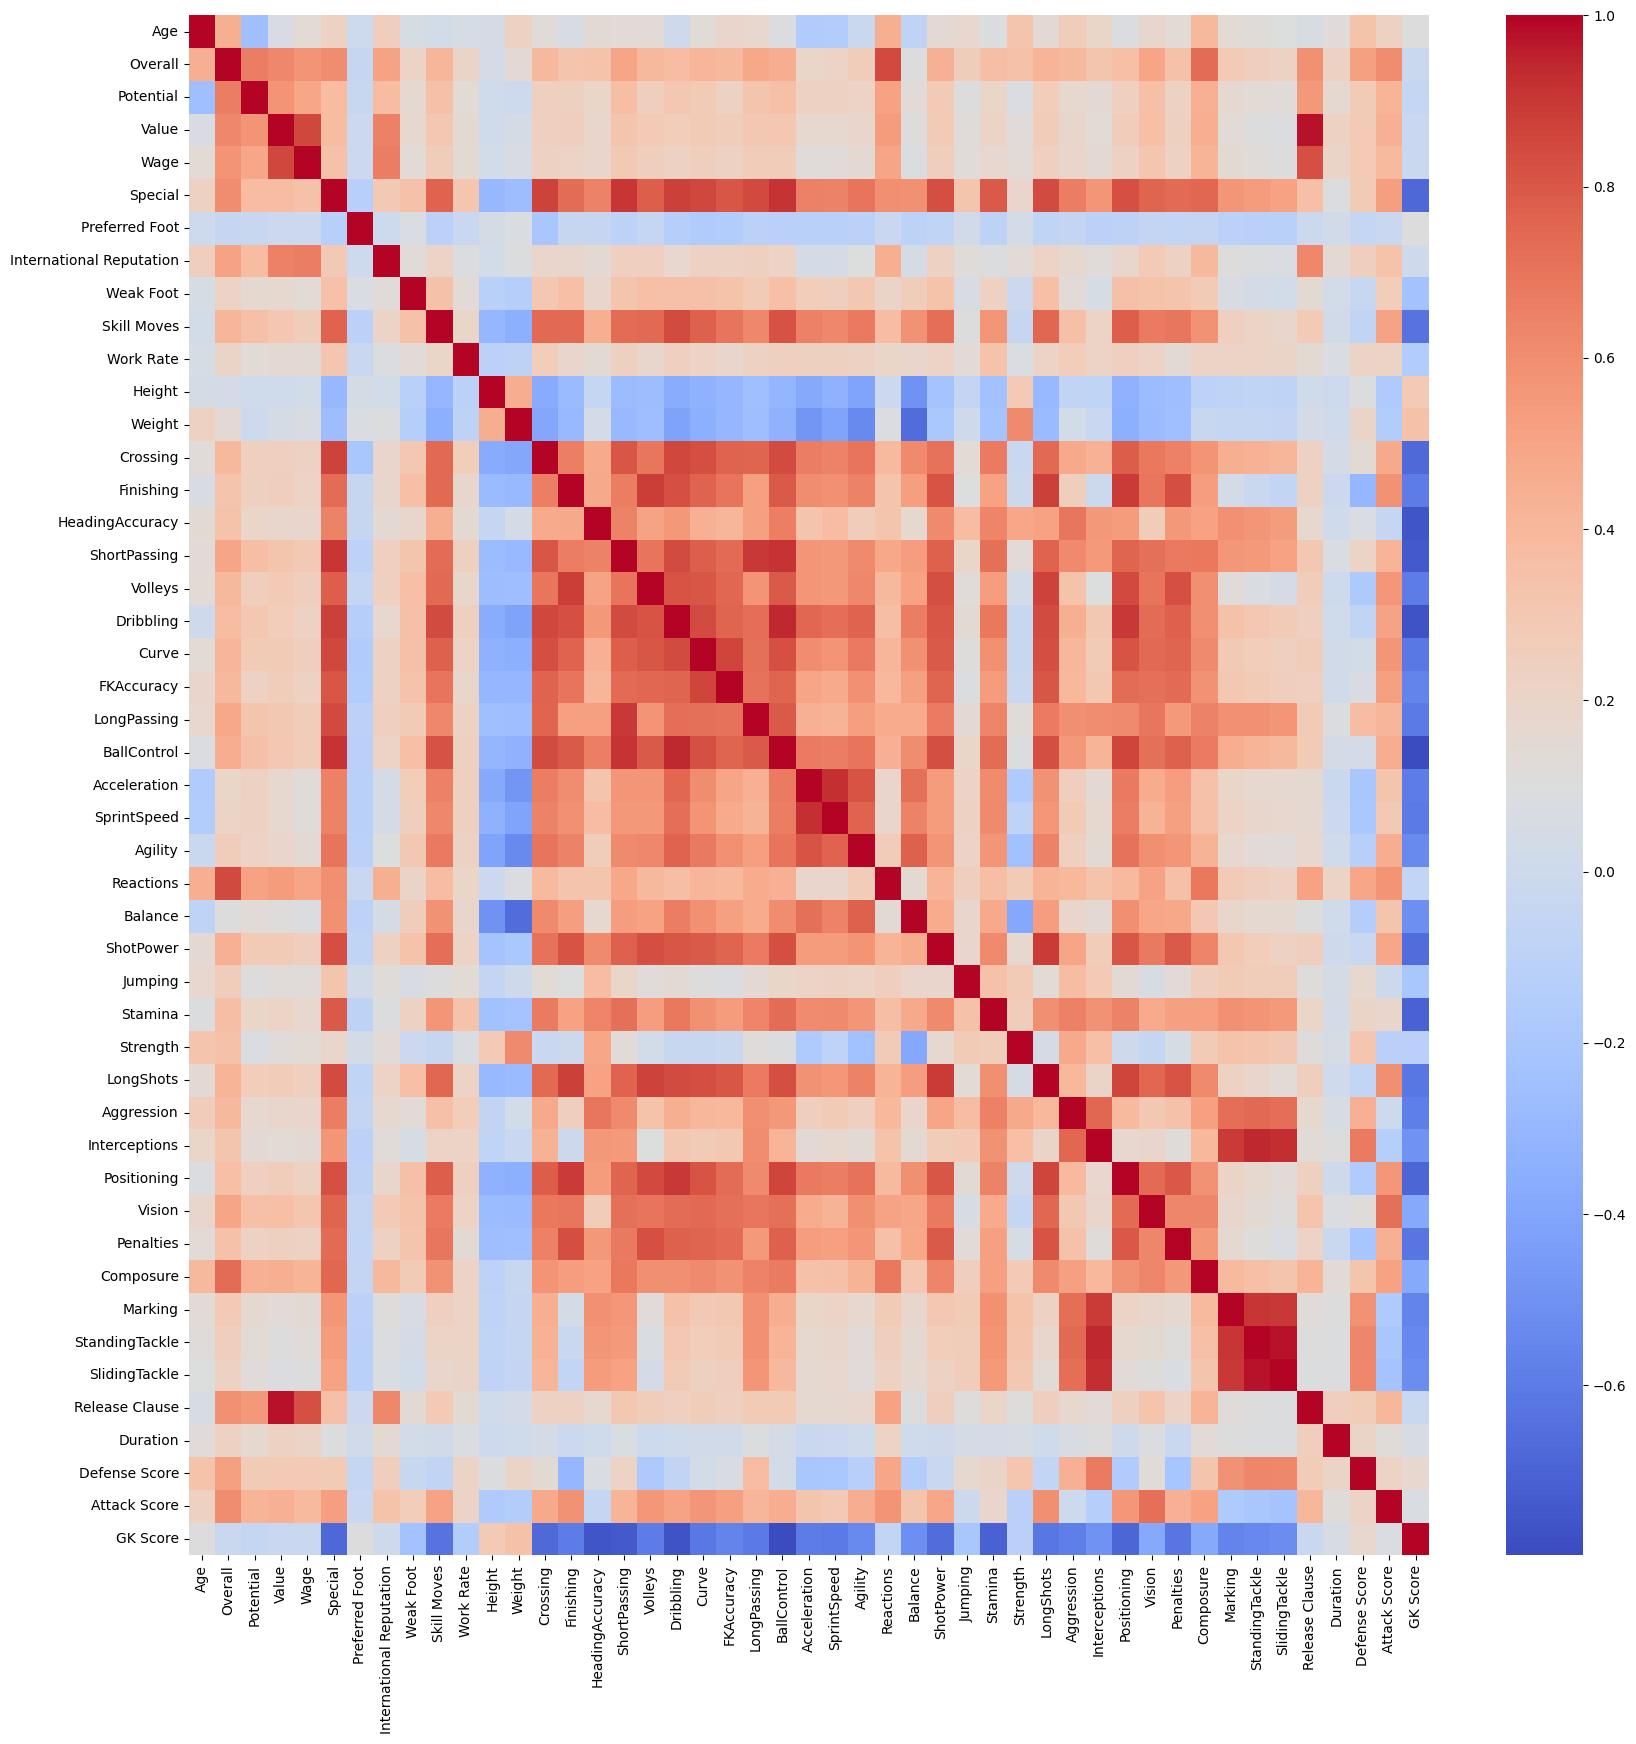

In [26]:
#Nuevo dataset
cor = data[varnum].drop('ID', axis=1).corr()

plt.figure(figsize=(20, 20))
sns.heatmap(cor, cmap='coolwarm')
plt.show()

Después de la inclusión de las variables de Defense Score y Attack Score se puede apreciar que el heatmap presenta menos valores hot lo que es mejor resultado sin embargo aún existen zonas donde se tiene correlación alta superior incluso a 0.9 que se abordará en la sección de reducción de dimensionalidad.

## EDA

In [27]:
datavisuals = data.copy()

### Distribución de Jugadores

In [28]:
#Jugadores en el mundo

def get_continent(country):
    try:
        country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = {
            'AF': 'Africa',
            'AS': 'Asia',
            'EU': 'Europe',
            'NA': 'North America',
            'SA': 'South America',
            'OC': 'Oceania',
            'AN': 'Antarctica'
        }
        return continent_name[continent_code]
    except:
        return 'Unknown'
    

datavisuals['Continent'] = datavisuals['Nationality'].apply(get_continent)

/Users/josemariareyesfigueroa/Library/Python/3.9/lib/python/site-packages/pycountry/db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)
/Users/josemariareyesfigueroa/Library/Python/3.9/lib/python/site-packages/pycountry/db.py:51: UserWarning: Country's common_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)


In [29]:
#Heatmap

europe = ['England', 'Republic of Ireland', 'Scotland', 'Wales', 'Northern Ireland','Bosnia Herzegovina', 'Kosovo', 'FYR Macedonia']

asia = ['China PR', 'Korea Republic', 'Korea DPR']

africa = ['DR Congo', 'Guinea Bissau', 'Central African Rep.', 'São Tomé & Príncipe']

south_am = ['Curacao', 'Antigua & Barbuda', 'Trinidad & Tobago', 'St Kitts Nevis', 'St Lucia']

for c in datavisuals[datavisuals['Continent'] == 'Unknown']['Nationality']:
    if c in europe:
        datavisuals['Continent'] = datavisuals['Continent'].replace('Unknown', 'Europe')
    elif c in asia:
        datavisuals['Continent'] = datavisuals['Continent'].replace('Unknown', 'Asia')
    elif c in africa:
        datavisuals['Continent'] = datavisuals['Continent'].replace('Unknown', 'Africa')
    elif c in south_am:
        datavisuals['Continent'] = datavisuals['Continent'].replace('Unknown', 'South America')

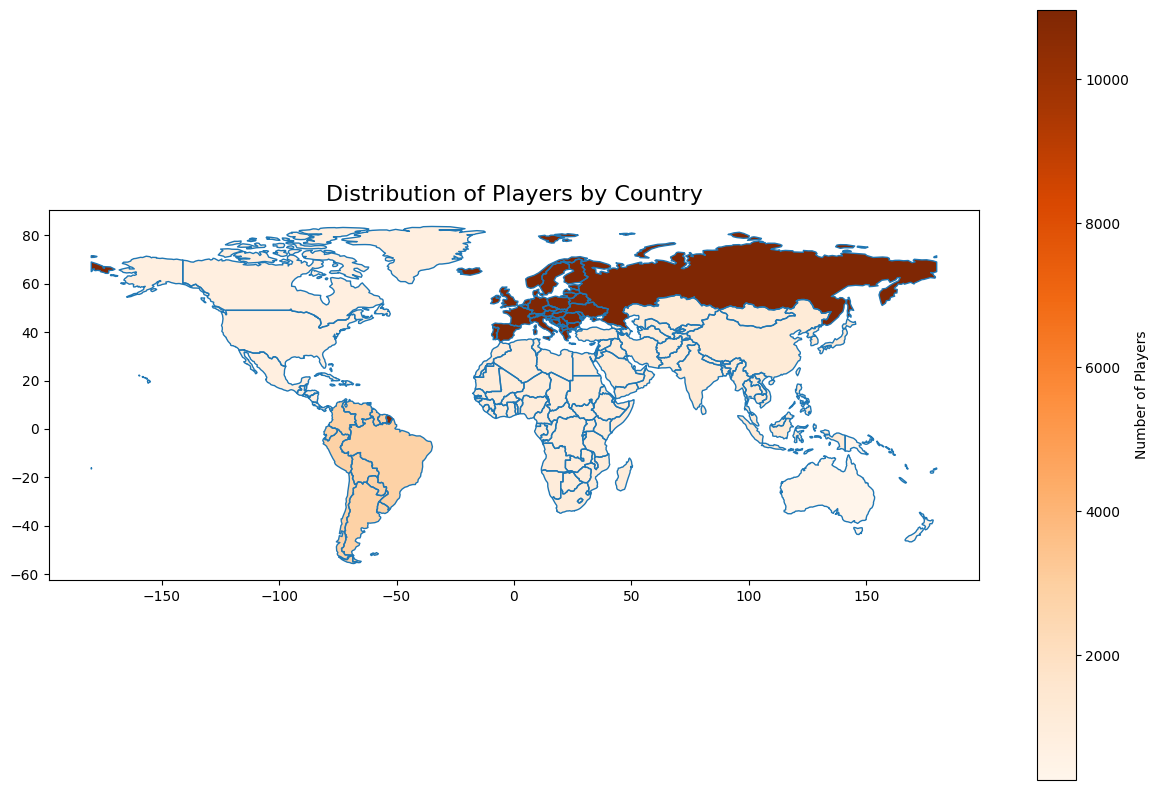

In [30]:
#Heatmap

g1 = datavisuals['Continent'].value_counts().reset_index()
g1.columns = ['Continent', 'Count']

# Cargar el shapefile del mapa mundial
world = gpd.read_file("./ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

# Mergear los datos con el mapa
world = world.merge(g1, left_on='CONTINENT', right_on='Continent')

# Reemplazar valores nulos por 0
world['Count'] = world['Count'].fillna(0)

# Graficar el mapa
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1)
world.plot(column='Count', ax=ax, legend=True, cmap='Oranges', legend_kwds={'label': "Number of Players"})
plt.title("Distribution of Players by Country", fontsize=16)
plt.show()

In [31]:
datavisuals.columns

Index(['ID', 'Age', 'Nationality', 'Overall', 'Potential', 'Club', 'Value',
       'Wage', 'Special', 'Preferred Foot', 'International Reputation',
       'Weak Foot', 'Skill Moves', 'Work Rate', 'Body Type', 'Position',
       'Height', 'Weight', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'Release Clause', 'Duration', 'Defense Score', 'Attack Score',
       'GK Score', 'Continent'],
      dtype='object')

/var/folders/p_/7q2hf8lx21bd_px0wvspdh480000gn/T/ipykernel_11355/1519560791.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gk['Value'])


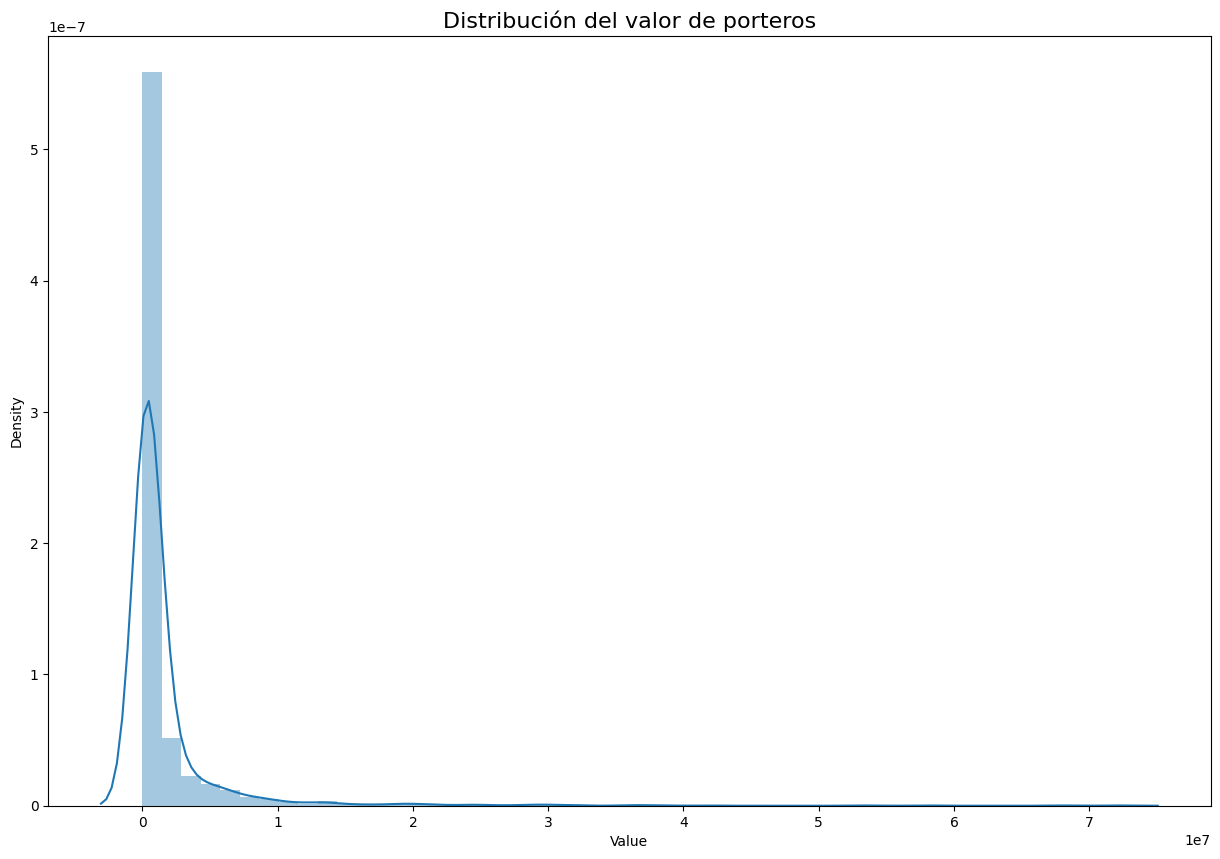

In [32]:
#Grafica posiciones vs value, frecuencias de las posiciones, posiciones por continente, overall vs value

#Posiciones vs Value

#Distribución de valur de Goalkeepers

gk = datavisuals[datavisuals['Position'] == 'Goalkeeper']
plt.figure(figsize=(15, 10))
sns.distplot(gk['Value'])
plt.title('Distribución del valor de porteros', fontsize=16)
plt.show()

/var/folders/p_/7q2hf8lx21bd_px0wvspdh480000gn/T/ipykernel_11355/2581784029.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(defenders['Value'])


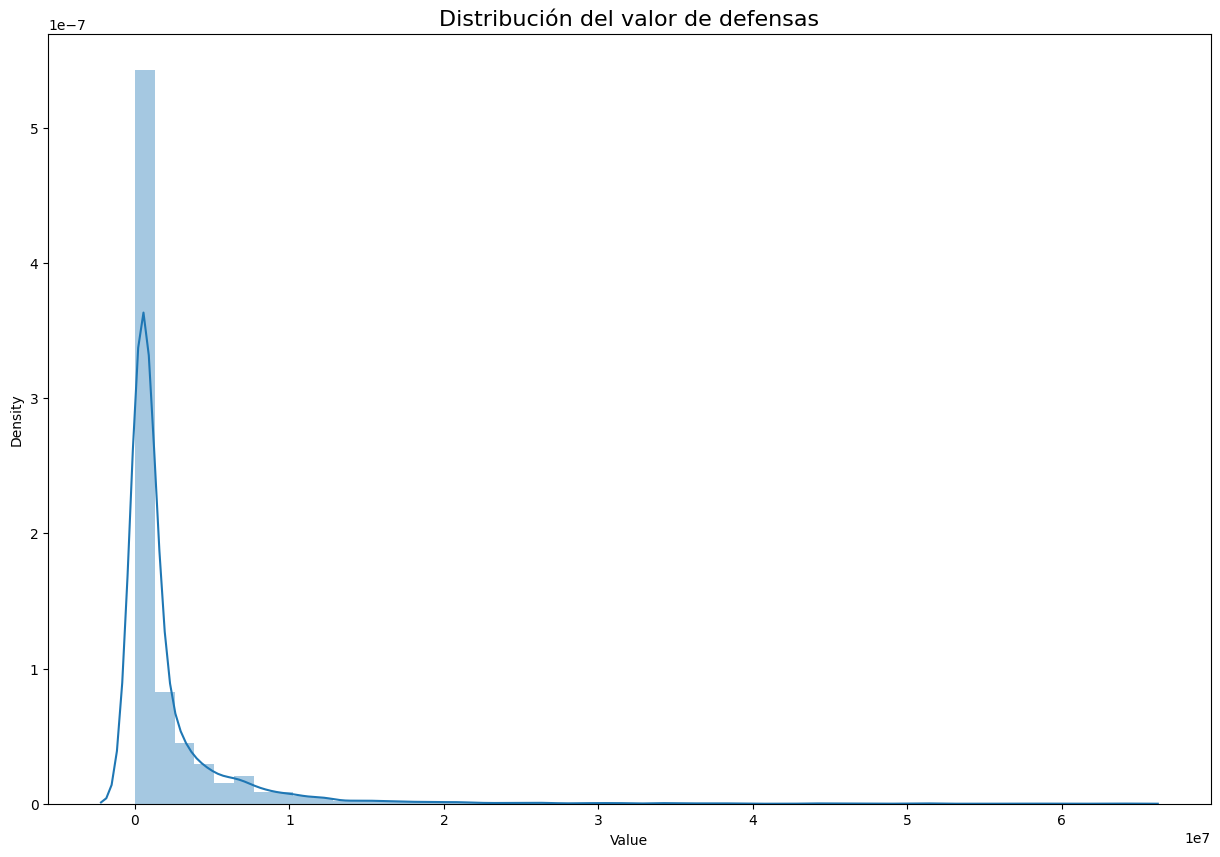

In [33]:
#Distribución de valur de Defenders

defenders = datavisuals[datavisuals['Position'] == 'Defender']
plt.figure(figsize=(15, 10))
sns.distplot(defenders['Value'])
plt.title('Distribución del valor de defensas', fontsize=16)
plt.show()

/var/folders/p_/7q2hf8lx21bd_px0wvspdh480000gn/T/ipykernel_11355/1924460353.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(midfielders['Value'])


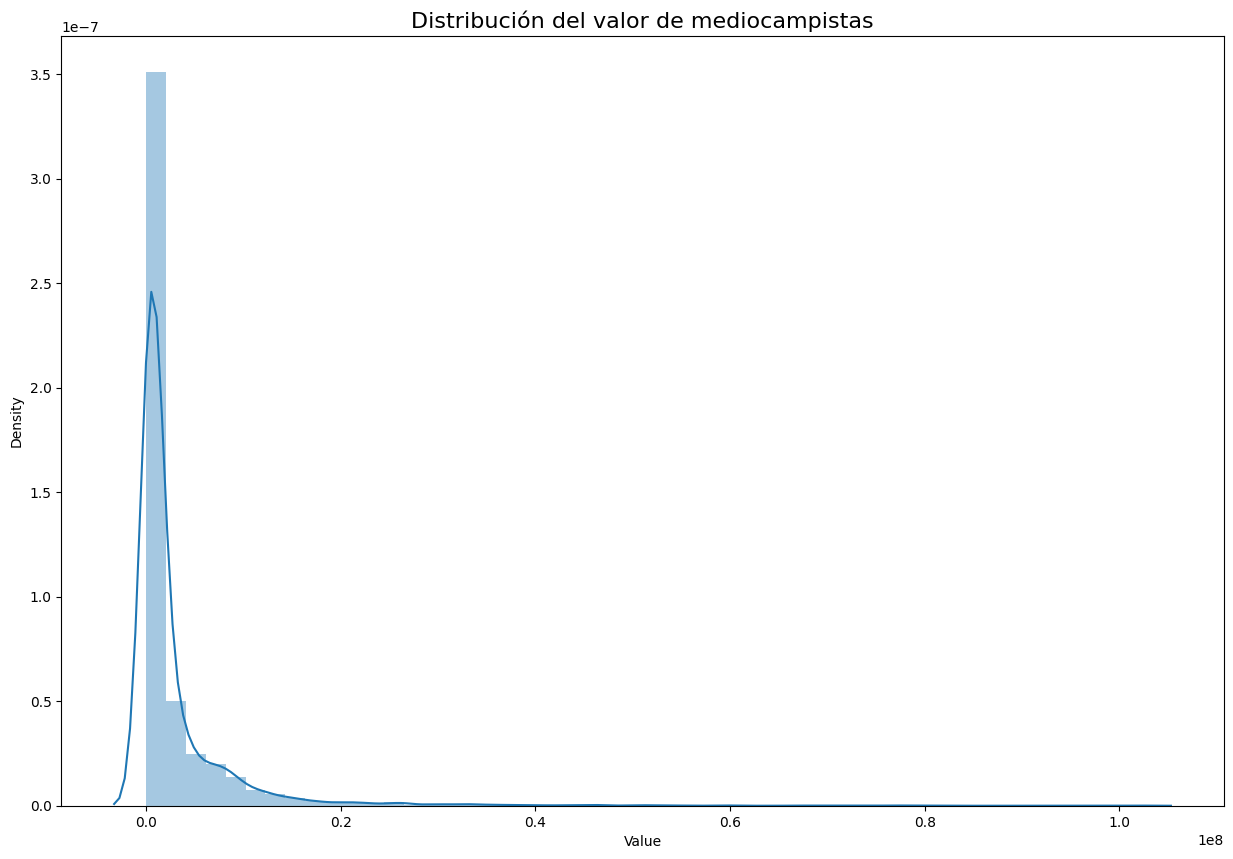

In [34]:
#Distribución de valur de Midfielders

midfielders = datavisuals[datavisuals['Position'] == 'Midfielder']
plt.figure(figsize=(15, 10))
sns.distplot(midfielders['Value'])
plt.title('Distribución del valor de mediocampistas', fontsize=16)
plt.show()

/var/folders/p_/7q2hf8lx21bd_px0wvspdh480000gn/T/ipykernel_11355/4038431097.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(forwards['Value'])


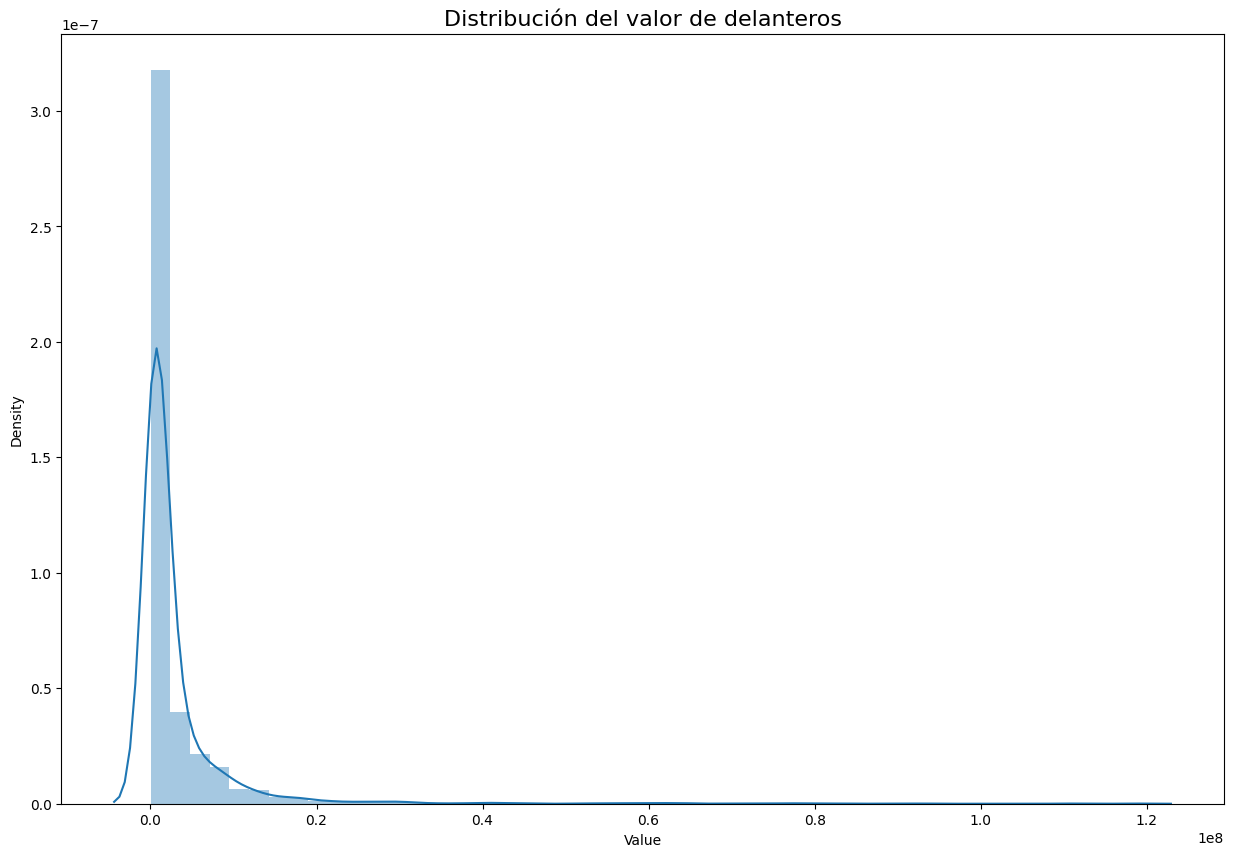

In [35]:
#Distribución de valur de Forwards

forwards = datavisuals[datavisuals['Position'] == 'Forward']
plt.figure(figsize=(15, 10))
sns.distplot(forwards['Value'])
plt.title('Distribución del valor de delanteros', fontsize=16)
plt.show()

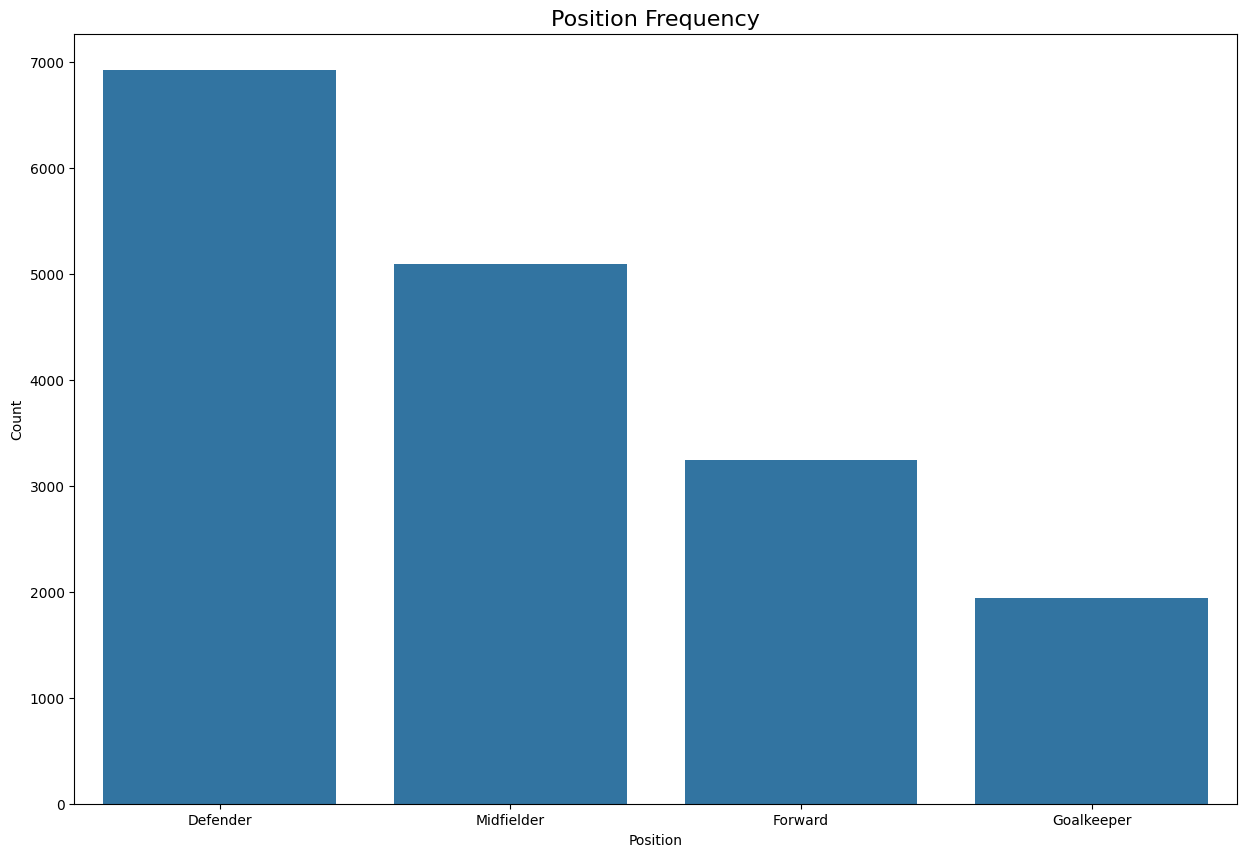

In [36]:
pos = datavisuals['Position'].value_counts().reset_index()
pos.columns = ['Position', 'Count']

plt.figure(figsize=(15, 10))
sns.barplot(x='Position', y='Count', data=pos)
plt.title('Position Frequency', fontsize=16)
plt.show()

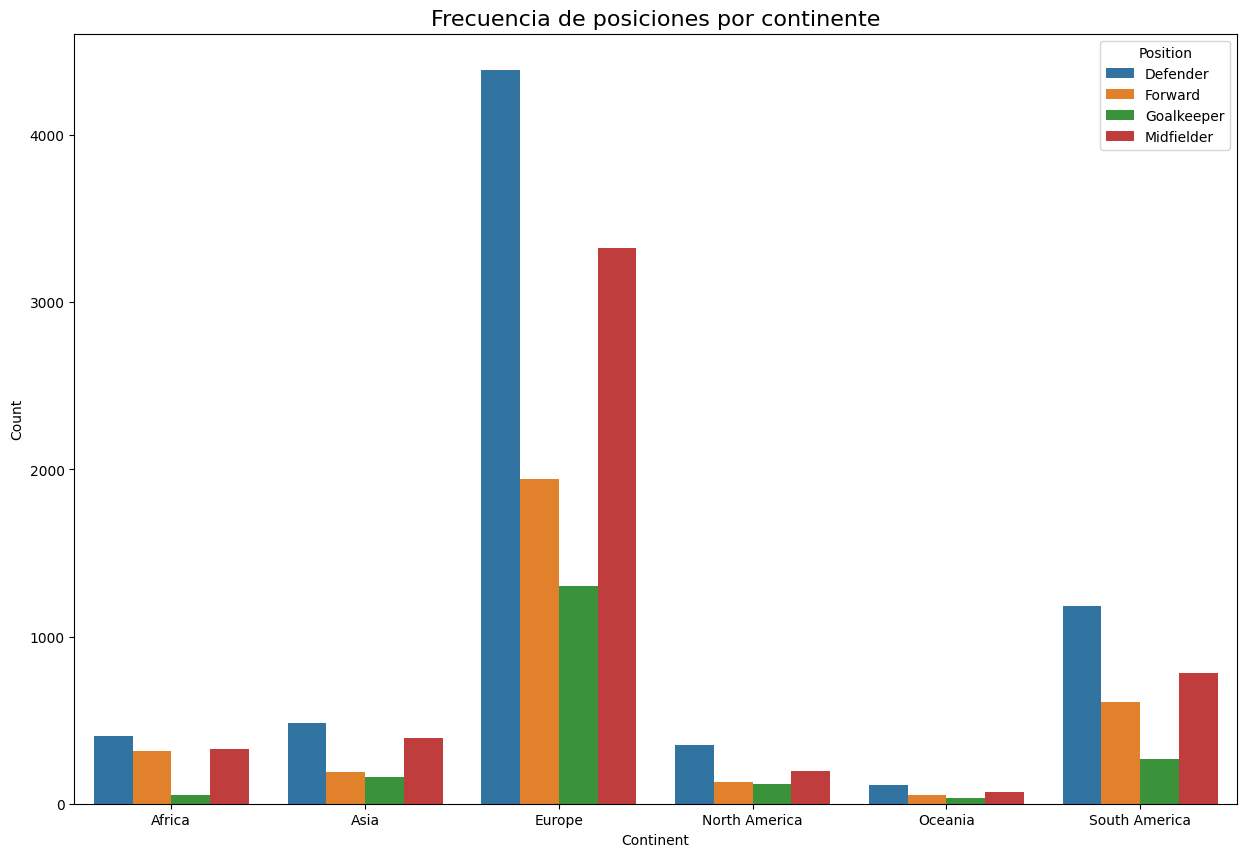

In [37]:
#Posiciones por continente

pos_cont = datavisuals.groupby(['Continent', 'Position']).size().reset_index()
pos_cont.columns = ['Continent', 'Position', 'Count']

plt.figure(figsize=(15, 10))
sns.barplot(x='Continent', y='Count', hue='Position', data=pos_cont)
plt.title('Frecuencia de posiciones por continente', fontsize=16)
plt.show()

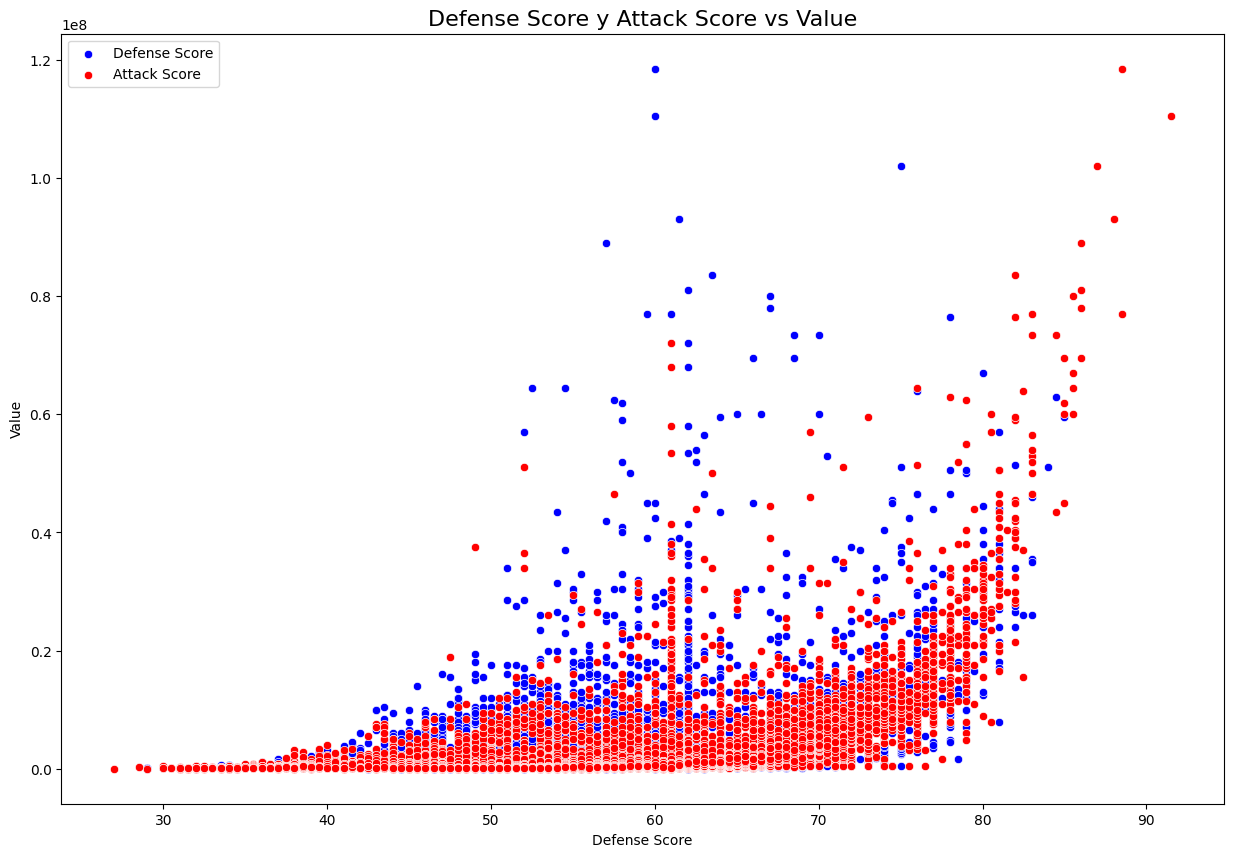

In [38]:
#Defense Score y Attack Score vs Value 

plt.figure(figsize=(15, 10))
sns.scatterplot(x='Defense Score', y='Value', data=datavisuals, color='blue', label='Defense Score')
sns.scatterplot(x='Attack Score', y='Value', data=datavisuals, color='red', label='Attack Score')
plt.title('Defense Score y Attack Score vs Value', fontsize=16)
plt.show()

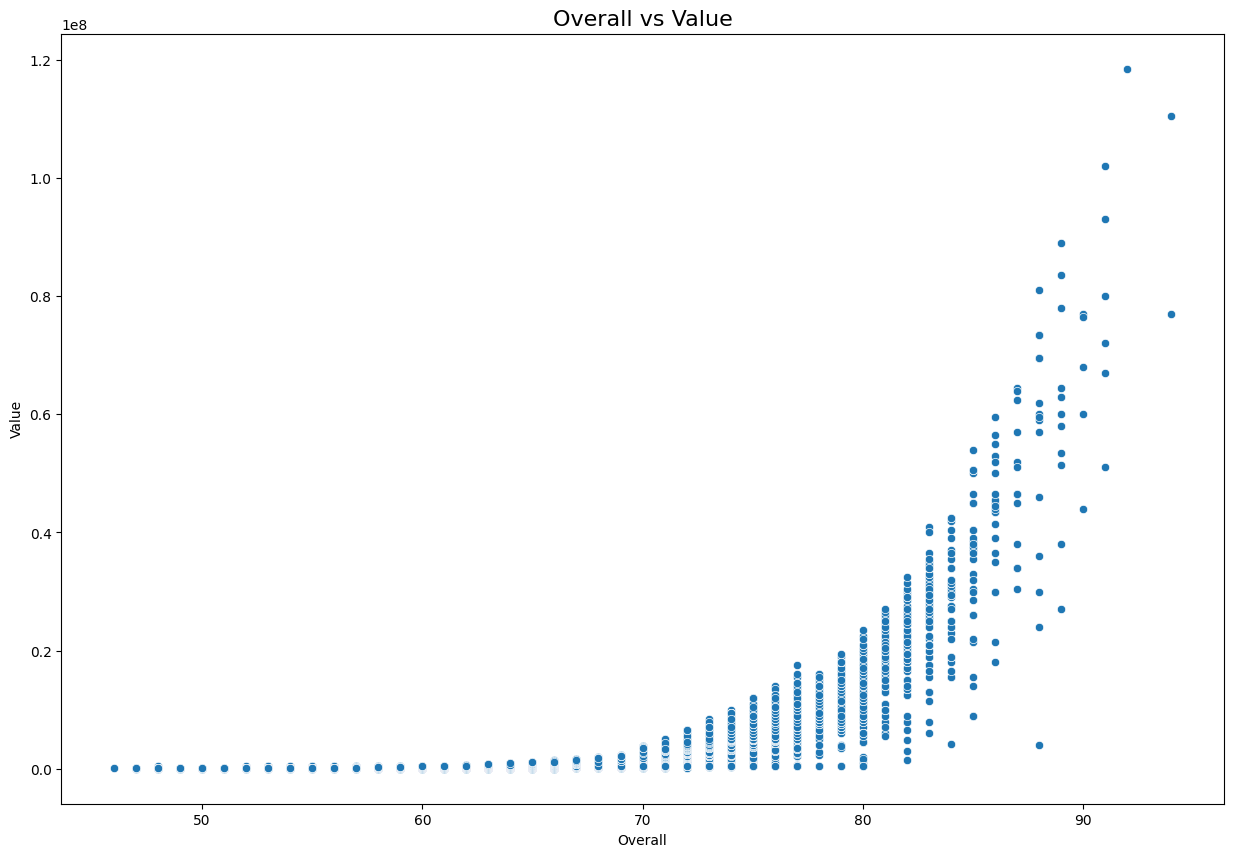

In [39]:
#Overall vs Value

plt.figure(figsize=(15, 10))
sns.scatterplot(x='Overall', y='Value', data=datavisuals)
plt.title('Overall vs Value', fontsize=16)
plt.show()

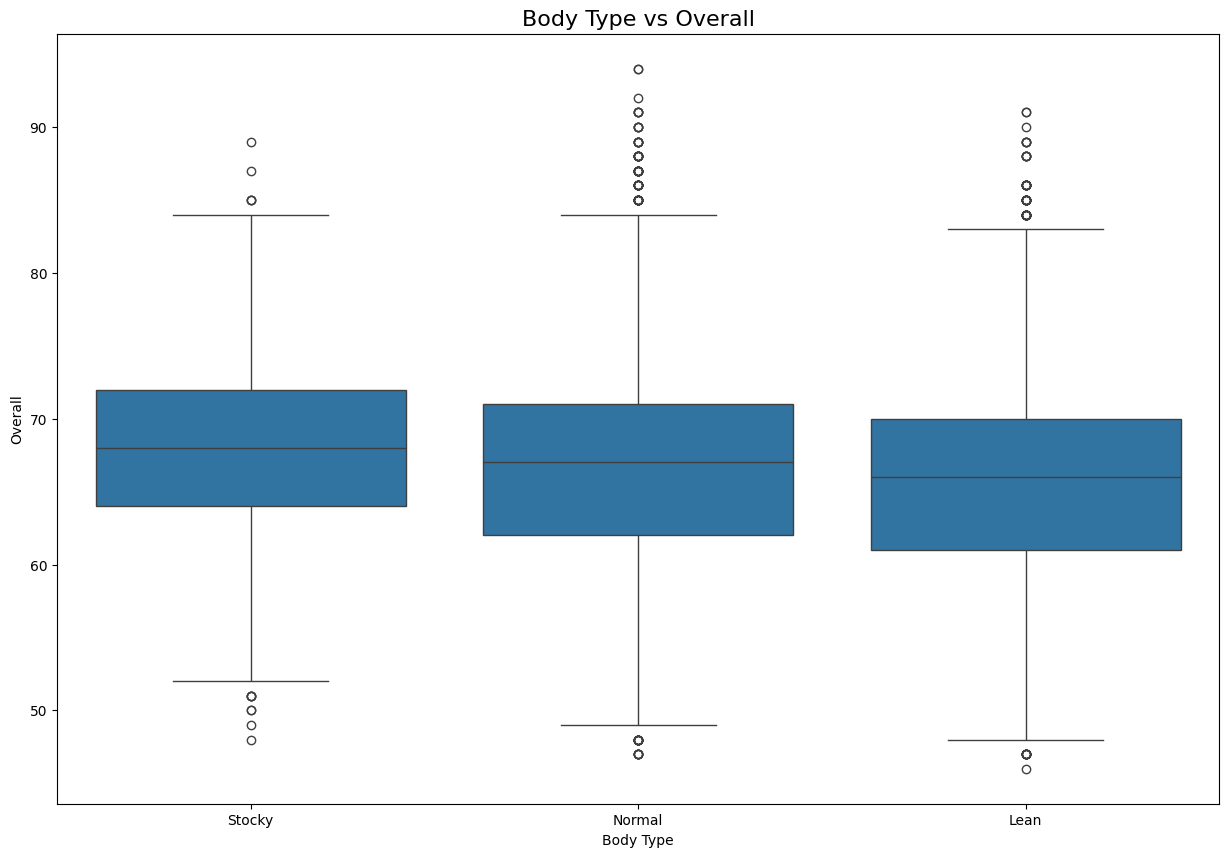

In [40]:
#Body Type vs Overall

plt.figure(figsize=(15, 10))
sns.boxplot(x='Body Type', y='Overall', data=datavisuals)
plt.title('Body Type vs Overall', fontsize=16)
plt.show()

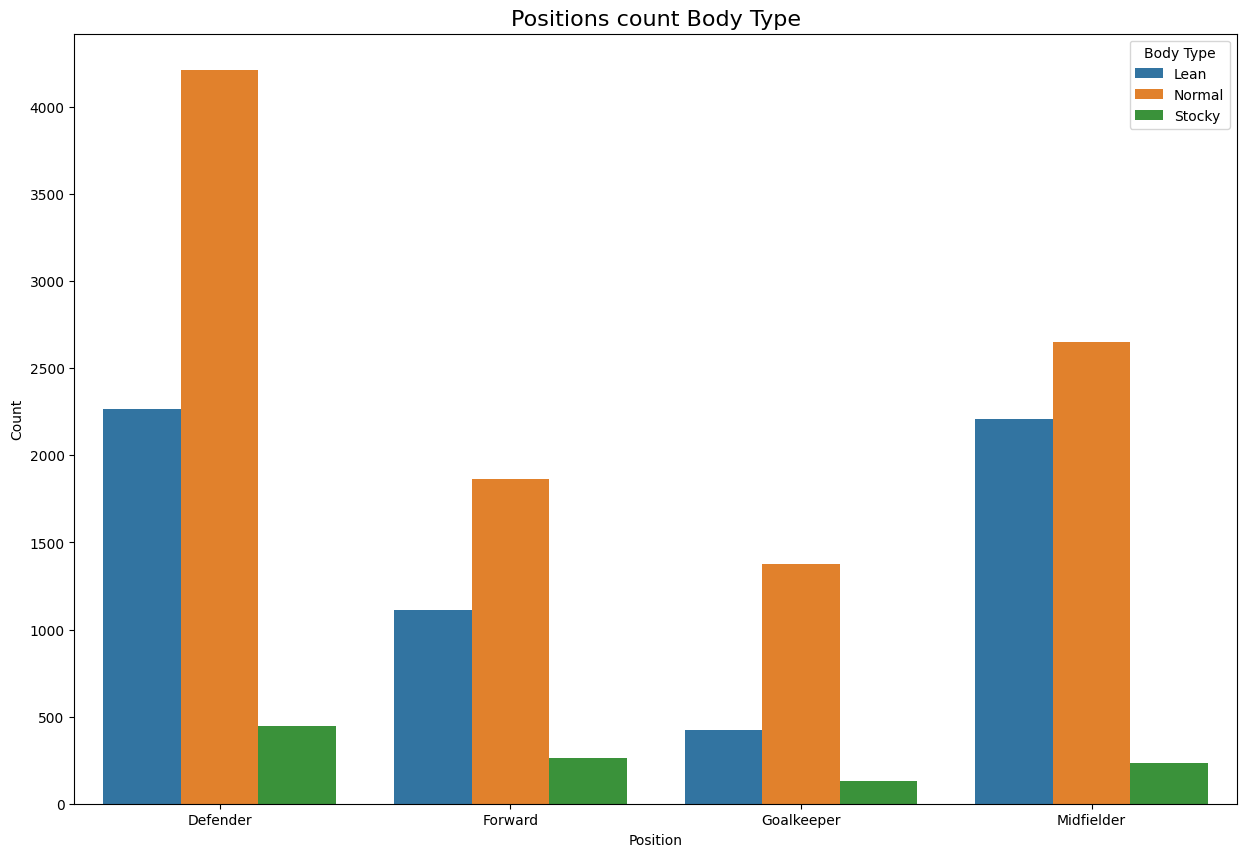

In [41]:
#Positions count Body Type

pos_body = datavisuals.groupby(['Position', 'Body Type']).size().reset_index()
pos_body.columns = ['Position', 'Body Type', 'Count']

plt.figure(figsize=(15, 10))
sns.barplot(x='Position', y='Count', hue='Body Type', data=pos_body)
plt.title('Positions count Body Type', fontsize=16)
plt.show()

## Estandarización

In [42]:
data = data.drop(['Club'], axis=1)


In [43]:
data['Continent'] = datavisuals['Continent']
data['Continent'] = data['Continent'].map({'Europe': 1, 'South America': 2, 'Africa': 3, 'Asia': 4, 'North America': 5, 'Oceania': 6})
data['Position'] = data['Position'].map({'Goalkeeper': 1, 'Defender': 2, 'Midfielder': 3, 'Forward': 4})
data['Body Type'] = data['Body Type'].map({'Normal': 1, 'Lean': 2, 'Stocky': 3})

In [44]:
#Definición de variables numéricas y no numéricas 4

varnum = data.select_dtypes(include=[np.number]).columns
varnonum = data.select_dtypes(exclude=[np.number]).columns

In [45]:
data = data.drop(['Nationality'], axis=1)

In [46]:
#Definición de variables numéricas y no numéricas 5

varnum = data.select_dtypes(include=[np.number]).columns
varnonum = data.select_dtypes(exclude=[np.number]).columns

varnum, varnonum

(Index(['ID', 'Age', 'Overall', 'Potential', 'Value', 'Wage', 'Special',
        'Preferred Foot', 'International Reputation', 'Weak Foot',
        'Skill Moves', 'Work Rate', 'Body Type', 'Position', 'Height', 'Weight',
        'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
        'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
        'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
        'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
        'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
        'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
        'Release Clause', 'Duration', 'Defense Score', 'Attack Score',
        'GK Score', 'Continent'],
       dtype='object'),
 Index([], dtype='object'))

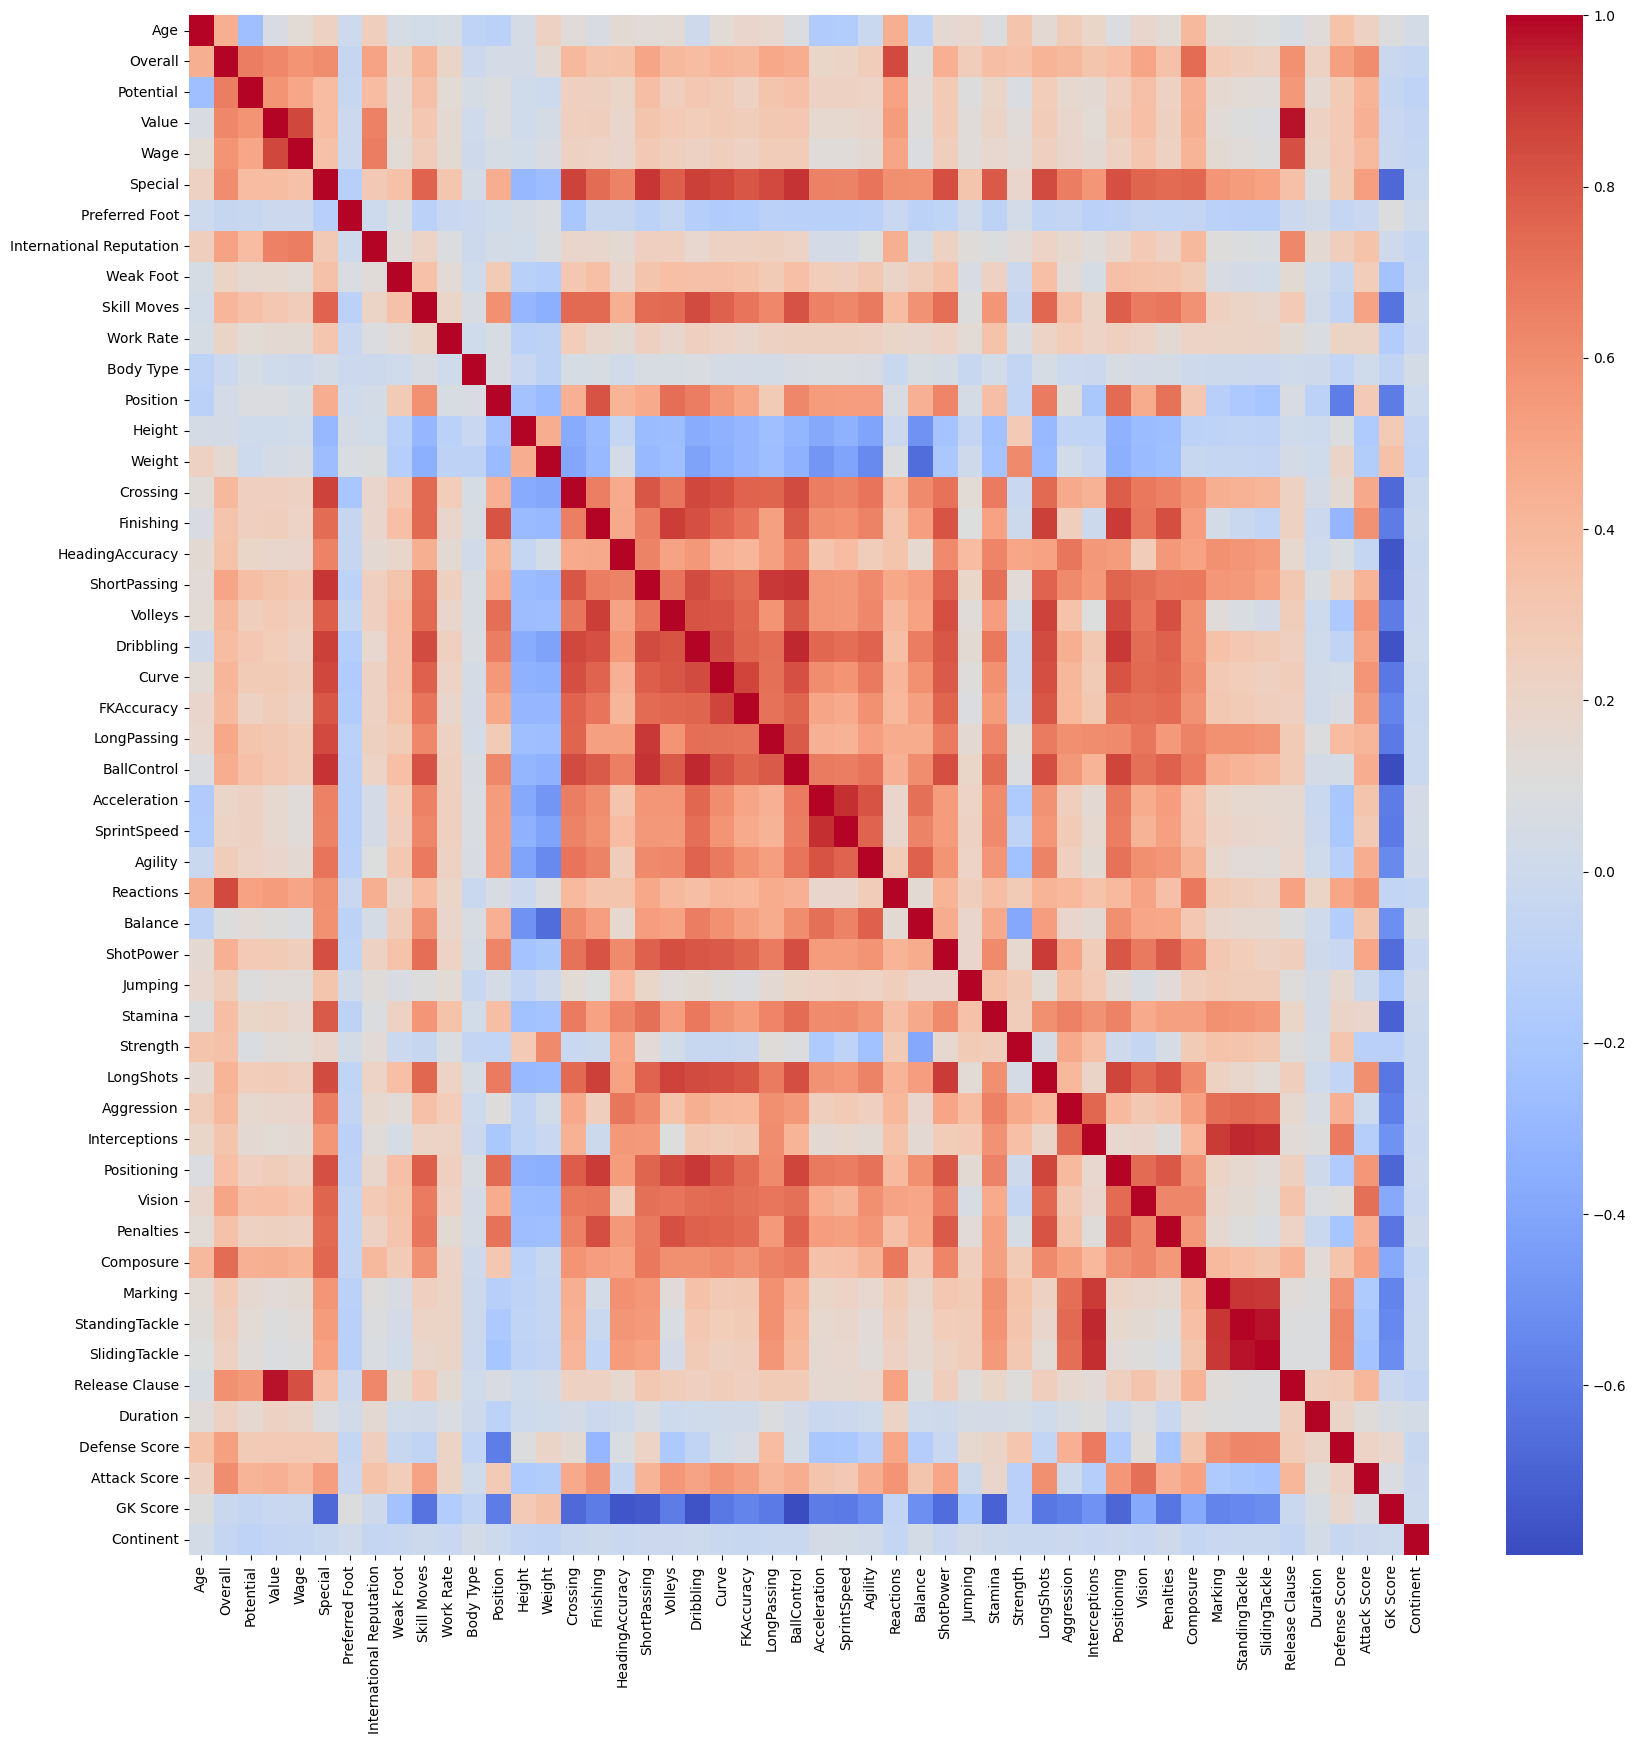

In [47]:
cor2 = data[varnum].drop('ID', axis=1).corr()

plt.figure(figsize=(20, 20))
sns.heatmap(cor2, cmap='coolwarm')
plt.show()

## Reducción de Dimensionalidad

### Análisis de Factores

In [48]:
data = data.drop(['ID'], axis=1)
dataAF = data.copy()

In [50]:
varnum = data.select_dtypes(include=[np.number]).columns

In [52]:
#Escalamiento

scaler = StandardScaler()
dataAF[varnum] = scaler.fit_transform(dataAF[varnum])
dataAF = pd.DataFrame(dataAF, columns=data.columns)
dataAF

Age   Overall  Potential     Value      Wage   Special  \
0      4.210983  0.680668  -0.039896 -0.403809 -0.081467 -1.252881   
1      3.997826 -2.655411  -3.782151 -0.338709 -0.401691 -3.014787   
2      3.997826 -1.930176  -2.968617 -0.338709 -0.401691 -2.459165   
3      3.571512 -0.189614  -1.016136 -0.425212 -0.401691 -1.106664   
4      3.358355  0.245527  -0.528016 -0.421645 -0.401691 -1.333300   
...         ...       ...        ...       ...       ...       ...   
17189 -1.970567 -2.220270  -0.853430 -0.419861 -0.401691 -0.967759   
17190 -1.970567 -2.075223  -0.365309 -0.414510 -0.401691 -0.653394   
17191 -1.970567 -1.059895   0.610931 -0.378839 -0.401691 -0.572975   
17192 -1.970567 -2.075223  -0.690723 -0.414510 -0.401691 -0.518144   
17193 -1.970567 -2.945505  -0.853430 -0.421645 -0.401691 -1.015279   

       Preferred Foot  International Reputation  Weak Foot  Skill Moves  \
0            0.546749                  2.226640   0.072855    -1.796395   
1            0.546749                 -0.291437  -1.440034    -1.796395   
2            0.546749                 -0.291437  -1.440034    -1.796395   
3            0.546749                  2.226640   0.072855    -1.796395   
4            0.546749                 -0.291437   0.072855    -1.796395   
...               ...                       ...        ...          ...   
17189        0.546749                 -0.291437   0.072855    -0.474168   
17190       -1.828992                 -0.291437   0.072855    -0.474168   
17191        0.546749                 -0.291437  -1.440034     0.848058   
17192        0.546749                 -0.291437  -1.440034    -0.474168   
17193        0.546749                 -0.291437   0.072855    -0.474168   

       Work Rate  Body Type  Position    Height    Weight  Crossing  \
0      -0.441132   2.493772 -1.694009 -0.002644 -0.076086 -1.671319   
1      -0.441132  -0.775857 -1.694009  0.888769  1.528941 -2.105881   
2      -0.441132  -0.775857 -1.694009  1.334476  1.207935 -1.671319   
3      -0.441132  -0.775857 -1.694009  0.888769  0.630126 -1.454038   
4      -0.441132  -0.775857 -1.694009 -1.562618 -0.332890 -1.345397   
...          ...        ...       ...       ...       ...       ...   
17189  -0.441132   0.858957  0.476635 -0.671204 -1.488510 -0.313313   
17190  -0.441132  -0.775857  0.476635 -0.225497 -1.167504 -0.150352   
17191  -0.441132   0.858957  1.561957 -1.540332 -0.782298 -0.639234   
17192  -0.441132  -0.775857  0.476635  0.220209 -0.782298 -0.856515   
17193  -0.441132   0.858957  0.476635 -1.562618  0.630126 -0.476274   

       Finishing  HeadingAccuracy  ShortPassing   Volleys  Dribbling  \
0      -1.612910        -1.623344     -2.222355 -1.686423  -2.286676   
1      -1.715270        -2.311042     -2.765436 -1.799077  -2.339453   
2      -1.664090        -2.139117     -2.358126 -1.573769  -2.181124   
3      -1.766450        -1.680652     -2.018700 -1.348462  -1.336706   
4      -1.561730        -2.253734     -1.543504 -1.742750  -1.758915   
...          ...              ...           ...       ...        ...   
17189  -0.282229        -0.763721     -0.525227  0.003384  -0.017302   
17190   0.383112        -0.706413     -0.185802 -0.334577  -0.386735   
17191   1.048453        -0.133331     -0.321572  0.960942   0.668787   
17192   0.024852        -0.362564     -0.050031  0.172365  -0.228407   
17193  -0.589309        -0.362564     -0.728883 -0.728866  -0.650616   

          Curve  FKAccuracy  LongPassing  BallControl  Acceleration  \
0     -1.907391   -1.307736    -1.681712    -2.113915     -0.297183   
1     -1.907391   -1.706765    -2.593959    -2.532203     -3.301745   
2     -1.798986   -1.763769    -1.877194    -1.874894     -2.767600   
3     -1.365367   -0.167654    -1.616552    -1.695628     -0.831327   
4     -1.527974   -1.307736    -1.225589    -1.635873     -0.764559   
...         ...         ...          ...          ...           ...   
17189 -0.389725   -0.395670    -0.443663    -0.321255  

In [53]:
#Esfericidad de Bartlett

chi, p = calculate_bartlett_sphericity(dataAF)
print('Valor de chi:', chi)
print('Valor de p:', p)

Valor de chi: 1268766.752740046
Valor de p: 0.0


In [55]:
#Prueba KMO 

kmo_all, kmo_model = calculate_kmo(dataAF)
print('Valor de KMO:', kmo_model)

Valor de KMO: 0.7601111179156814


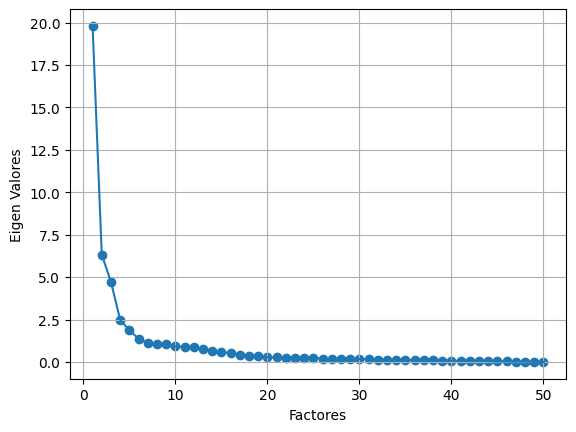

In [58]:
#Numero de factores

fa = FactorAnalyzer(rotation = None,impute = "drop",n_factors=dataAF.shape[1])
fa.fit(dataAF)

ev, v = fa.get_eigenvalues()

plt.scatter(range(1,dataAF.shape[1]+1),ev)
plt.plot(range(1,dataAF.shape[1]+1),ev)
plt.xlabel('Factores')
plt.ylabel('Eigen Valores')
plt.grid()

In [60]:
#Modelo de factores

fa = FactorAnalyzer(n_factors=9, rotation="varimax")
fa.fit(dataAF)

FactorAnalyzer(n_factors=9, rotation='varimax', rotation_kwargs={})

In [61]:
cm = sns.light_palette("blue", as_cmap=True)
cargas = pd.DataFrame(fa.loadings_, index=dataAF.columns).style.background_gradient(cmap=cm)
cargas

In [62]:
dataAF

Age   Overall  Potential     Value      Wage   Special  \
0      4.210983  0.680668  -0.039896 -0.403809 -0.081467 -1.252881   
1      3.997826 -2.655411  -3.782151 -0.338709 -0.401691 -3.014787   
2      3.997826 -1.930176  -2.968617 -0.338709 -0.401691 -2.459165   
3      3.571512 -0.189614  -1.016136 -0.425212 -0.401691 -1.106664   
4      3.358355  0.245527  -0.528016 -0.421645 -0.401691 -1.333300   
...         ...       ...        ...       ...       ...       ...   
17189 -1.970567 -2.220270  -0.853430 -0.419861 -0.401691 -0.967759   
17190 -1.970567 -2.075223  -0.365309 -0.414510 -0.401691 -0.653394   
17191 -1.970567 -1.059895   0.610931 -0.378839 -0.401691 -0.572975   
17192 -1.970567 -2.075223  -0.690723 -0.414510 -0.401691 -0.518144   
17193 -1.970567 -2.945505  -0.853430 -0.421645 -0.401691 -1.015279   

       Preferred Foot  International Reputation  Weak Foot  Skill Moves  \
0            0.546749                  2.226640   0.072855    -1.796395   
1            0.546749                 -0.291437  -1.440034    -1.796395   
2            0.546749                 -0.291437  -1.440034    -1.796395   
3            0.546749                  2.226640   0.072855    -1.796395   
4            0.546749                 -0.291437   0.072855    -1.796395   
...               ...                       ...        ...          ...   
17189        0.546749                 -0.291437   0.072855    -0.474168   
17190       -1.828992                 -0.291437   0.072855    -0.474168   
17191        0.546749                 -0.291437  -1.440034     0.848058   
17192        0.546749                 -0.291437  -1.440034    -0.474168   
17193        0.546749                 -0.291437   0.072855    -0.474168   

       Work Rate  Body Type  Position    Height    Weight  Crossing  \
0      -0.441132   2.493772 -1.694009 -0.002644 -0.076086 -1.671319   
1      -0.441132  -0.775857 -1.694009  0.888769  1.528941 -2.105881   
2      -0.441132  -0.775857 -1.694009  1.334476  1.207935 -1.671319   
3      -0.441132  -0.775857 -1.694009  0.888769  0.630126 -1.454038   
4      -0.441132  -0.775857 -1.694009 -1.562618 -0.332890 -1.345397   
...          ...        ...       ...       ...       ...       ...   
17189  -0.441132   0.858957  0.476635 -0.671204 -1.488510 -0.313313   
17190  -0.441132  -0.775857  0.476635 -0.225497 -1.167504 -0.150352   
17191  -0.441132   0.858957  1.561957 -1.540332 -0.782298 -0.639234   
17192  -0.441132  -0.775857  0.476635  0.220209 -0.782298 -0.856515   
17193  -0.441132   0.858957  0.476635 -1.562618  0.630126 -0.476274   

       Finishing  HeadingAccuracy  ShortPassing   Volleys  Dribbling  \
0      -1.612910        -1.623344     -2.222355 -1.686423  -2.286676   
1      -1.715270        -2.311042     -2.765436 -1.799077  -2.339453   
2      -1.664090        -2.139117     -2.358126 -1.573769  -2.181124   
3      -1.766450        -1.680652     -2.018700 -1.348462  -1.336706   
4      -1.561730        -2.253734     -1.543504 -1.742750  -1.758915   
...          ...              ...           ...       ...        ...   
17189  -0.282229        -0.763721     -0.525227  0.003384  -0.017302   
17190   0.383112        -0.706413     -0.185802 -0.334577  -0.386735   
17191   1.048453        -0.133331     -0.321572  0.960942   0.668787   
17192   0.024852        -0.362564     -0.050031  0.172365  -0.228407   
17193  -0.589309        -0.362564     -0.728883 -0.728866  -0.650616   

          Curve  FKAccuracy  LongPassing  BallControl  Acceleration  \
0     -1.907391   -1.307736    -1.681712    -2.113915     -0.297183   
1     -1.907391   -1.706765    -2.593959    -2.532203     -3.301745   
2     -1.798986   -1.763769    -1.877194    -1.874894     -2.767600   
3     -1.365367   -0.167654    -1.616552    -1.695628     -0.831327   
4     -1.527974   -1.307736    -1.225589    -1.635873     -0.764559   
...         ...         ...          ...          ...           ...   
17189 -0.389725   -0.395670    -0.443663    -0.321255  

In [63]:
fa.get_factor_variance()

(array([15.94271855,  7.18166238,  4.58066593,  2.69542241,  1.74667756,
         1.66716057,  1.63663957,  1.03879529,  0.66976638]),
 array([0.31885437, 0.14363325, 0.09161332, 0.05390845, 0.03493355,
        0.03334321, 0.03273279, 0.02077591, 0.01339533]),
 array([0.31885437, 0.46248762, 0.55410094, 0.60800939, 0.64294294,
        0.67628615, 0.70901894, 0.72979484, 0.74319017]))

### PCA

In [69]:
dataPCA = dataAF.copy()
pca2 = PCA(n_components=2)
pca2.fit(dataPCA)
pca2.explained_variance_ratio_.sum()

0.5224264400763501

In [70]:
pca3 = PCA(n_components=3)
pca3.fit(dataPCA)
pca3.explained_variance_ratio_.sum()

0.6166584638505588

In [75]:
pcaF = PCA(n_components=0.9)
pcaF.fit(dataPCA)
pcaF.explained_variance_ratio_.__len__()

17

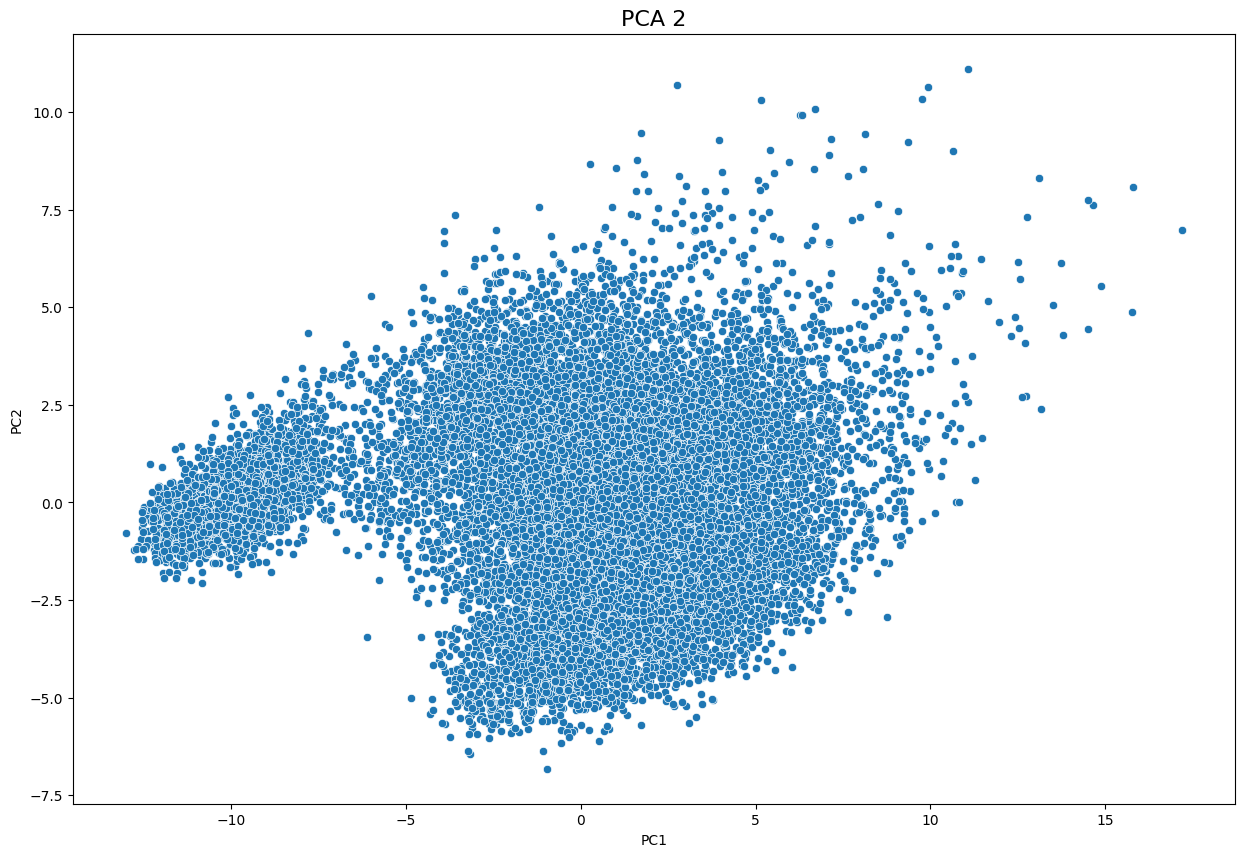

In [76]:
#PCA 2 - Grafica

dataPCA2 = pca2.transform(dataPCA)
dataPCA2 = pd.DataFrame(dataPCA2, columns=['PC1', 'PC2'])

plt.figure(figsize=(15, 10))
sns.scatterplot(x='PC1', y='PC2', data=dataPCA2)
plt.title('PCA 2', fontsize=16)
plt.show()

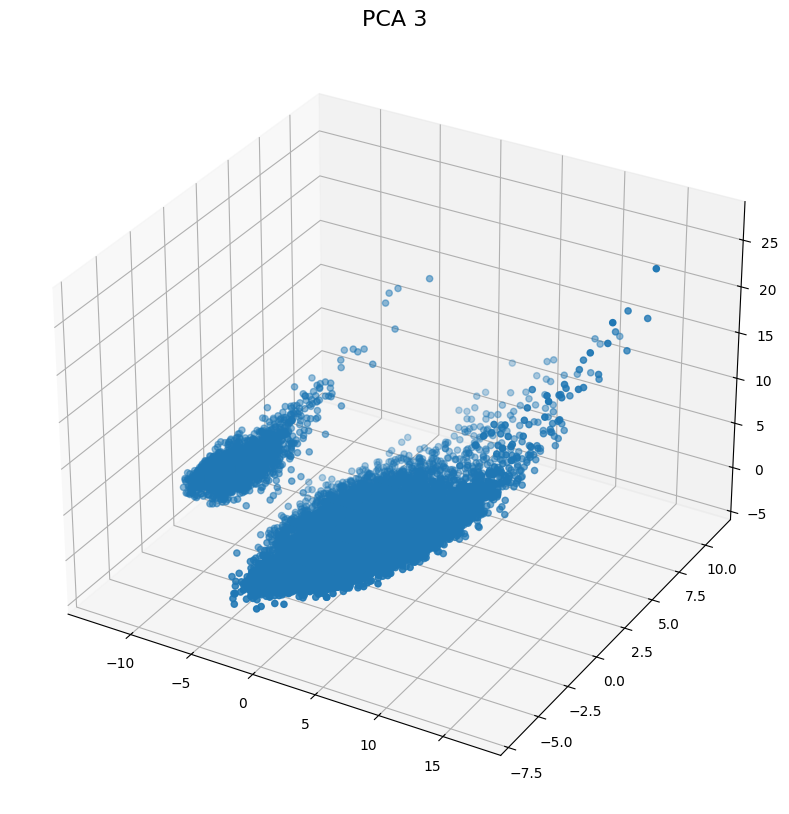

In [77]:
#PCA 3 - Grafica

dataPCA3 = pca3.transform(dataPCA)
dataPCA3 = pd.DataFrame(dataPCA3, columns=['PC1', 'PC2', 'PC3'])

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataPCA3['PC1'], dataPCA3['PC2'], dataPCA3['PC3'])
plt.title('PCA 3', fontsize=16)
plt.show()

In [78]:
#PCA 3 - Plotly

import plotly.express as px

fig = px.scatter_3d(dataPCA3, x='PC1', y='PC2', z='PC3')
fig.show()


/Users/josemariareyesfigueroa/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning:

urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020



## Selección de Número de Variables

In [81]:
#data2 será el dataset resultante de el analisis factorial en DataFrame

data2 = fa.transform(dataAF)
data2 = pd.DataFrame(data2, columns=['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5', 'Factor 6', 'Factor 7', 'Factor 8', 'Factor 9'])
data2

Factor 1  Factor 2  Factor 3  Factor 4  Factor 5  Factor 6  Factor 7  \
0     -2.210888 -1.408524  0.774091  1.618932  1.988569  4.184401  1.089737   
1     -1.460604 -1.318423  0.603872  0.301761 -2.454012  3.853500 -4.157461   
2     -1.360222 -1.247237  0.466405 -0.071124 -1.938790  3.729830 -3.273727   
3     -1.726328 -1.061038  0.471121  0.834201  0.654560  3.535233 -0.325186   
4     -1.790546 -1.264732  0.345802  0.923828  0.449061  3.286436  0.591477   
...         ...       ...       ...       ...       ...       ...       ...   
17189 -0.285995 -0.600845 -0.258777  1.825641 -0.589131 -1.304865 -1.276545   
17190 -0.192066 -0.567225 -0.312854  1.511873 -0.483130 -1.444980 -1.384151   
17191  0.725431 -1.556701 -0.497787  0.358331 -0.404885 -1.871534 -0.152405   
17192 -0.163750  0.294146 -0.398671  0.772888 -0.598655 -1.430508 -1.448214   
17193 -0.864518 -0.442216 -0.182546  0.330938 -1.563322 -1.916055 -2.540221   

       Factor 8  Factor 9  
0      0.152368 -0.953400  
1      0.849923 -0.240834  
2      1.030703 -0.049091  
3      0.967526  0.176636  
4      0.472408  0.188992  
...         ...       ...  
17189 -0.973038 -0.507684  
17190 -0.630304  0.307799  
17191 -1.212505 -0.476994  
17192  0.028430 -0.542374  
17193 -0.578675  0.421436  

[17194 rows x 9 columns]

In [80]:
#data3 será PCA F en DataFrame

data3 = pcaF.transform(dataPCA)
data3 = pd.DataFrame(data3)
data3.columns = ['PC' + str(i) for i in range(1, data3.shape[1] + 1)]
data3

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0      -6.624884  1.642021  4.934911  2.212365 -2.352862 -5.880961  4.305094   
1     -11.999240  0.117624  1.972156 -1.541672 -3.299522  0.331531  2.909523   
2     -10.783595  0.302265  1.877432 -1.870014 -3.156563  0.627222  1.860637   
3      -6.550302  1.328187  3.810839  1.117236 -3.021573 -3.265648  3.532778   
4      -7.205153  0.495098  2.661624  0.868262 -3.143028 -2.780381  1.223349   
...          ...       ...       ...       ...       ...       ...       ...   
17189  -2.646328 -3.772743 -1.337215  1.850827  1.055634  1.328400  0.971224   
17190  -2.068895 -3.950194 -1.983958  1.836880  0.931232  0.945028  1.563551   
17191  -0.609355 -5.448170  0.053250 -0.207211  1.867112  1.110368 -0.185520   
17192  -2.077057 -2.025139 -1.940297  0.877992  1.184478  1.354492  0.395417   
17193  -3.706661 -1.673770 -2.307185  0.368853  1.617658  1.353188  0.676886   

            PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0      0.684653  5.099940  1.323614  3.948914  6.944555  1.752663 -0.695684   
1      0.159000 -1.485498  2.115968  1.427675 -0.175243 -0.537620 -1.466701   
2      0.290146 -1.599584  1.711471  0.455202 -1.251844 -0.689583 -1.682370   
3      0.038057  1.698846 -0.263727  4.033681  4.126357  1.376604 -1.651480   
4     -0.163536 -0.667688  0.439069 -0.673131  0.639634  0.288345  0.764328   
...         ...       ...       ...       ...       ...       ...       ...   
17189 -1.053037  0.148239  0.837933 -0.001154  0.576500 -0.160929  0.030090   
17190  1.919246  0.146450 -1.964407  0.510684 -1.949158  1.281002  0.603406   
17191 -0.003996  0.177581  0.252030 -0.663067  0.153926 -2.023416  1.388813   
17192 -0.480594 -0.894339 -0.512930  0.179574  0.285240 -1.367680 -0.460065   
17193 -0.969194 -0.219604  1.044587 -0.484294 -0.577168 -0.245033  1.233804   

           PC15      PC16      PC17  
0     -0.346054 -0.504894 -2.448149  
1      0.068068 -0.567863  0.913192  
2      0.163832 -0.263581  0.936276  
3     -0.267613  0.546966 -2.354359  
4      1.064513 -0.707431  0.247937  
...         ...       ...       ...  
17189 -0.311256 -0.702914  0.088666  
17190 -1.116772  0.269231 -0.269168  
17191  0.105345 -0.373194 -0.305006  
17192 -0.940964  0.648008 -0.484594  
17193  0.871185  0.933865 -0.332557  

[17194 rows x 17 columns]

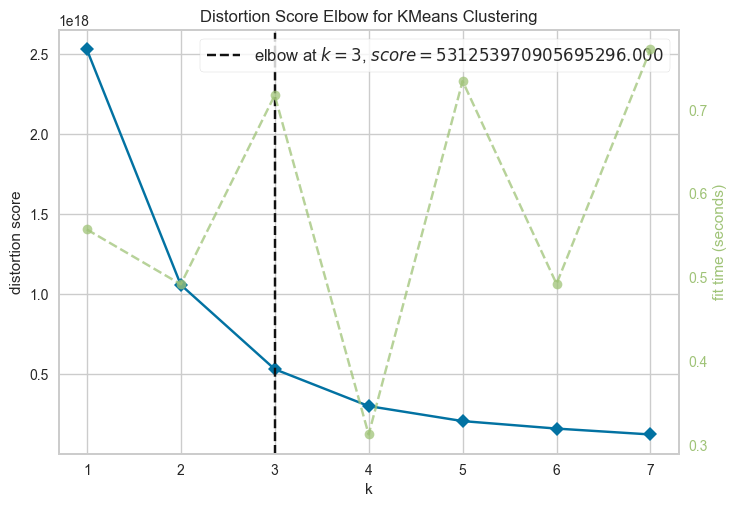

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [86]:
#Método del codo - KMeans

#Codo data 

model = KMeans(init='k-means++', max_iter=50, n_init=10)
visualizer = KElbowVisualizer(model, k=(1,8)).fit(data)
visualizer.show()

/Users/josemariareyesfigueroa/Library/Python/3.9/lib/python/site-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning:

No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.

/Users/josemariareyesfigueroa/Library/Python/3.9/lib/python/site-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning:

No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning



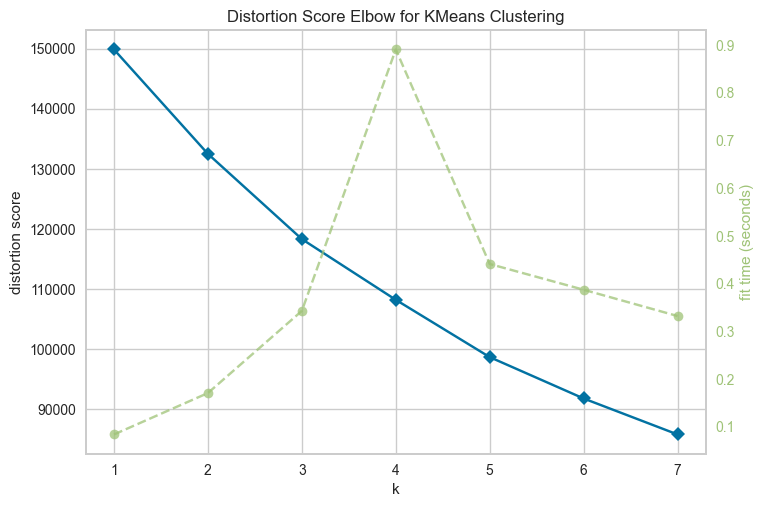

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [87]:
#Codo data2

model = KMeans(init='k-means++', max_iter=50, n_init=10)
visualizer = KElbowVisualizer(model, k=(1,8)).fit(data2)
visualizer.show()

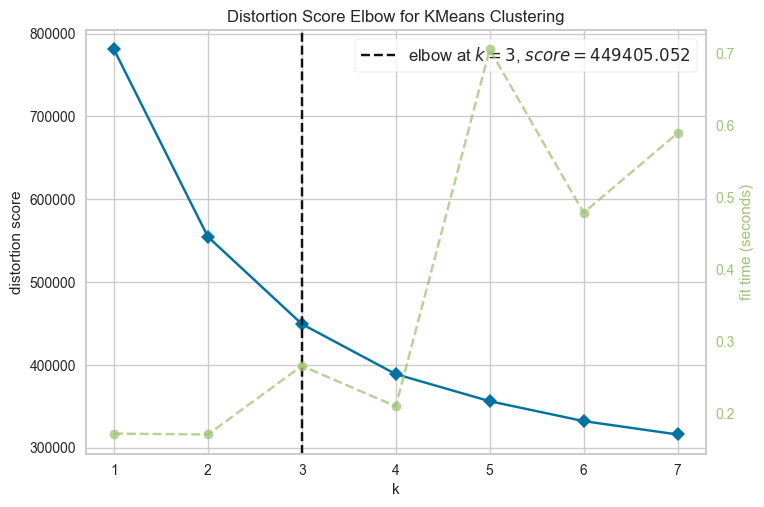

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [88]:
#Codo data3

model = KMeans(init='k-means++', max_iter=50, n_init=10)
visualizer = KElbowVisualizer(model, k=(1,8)).fit(data3)
visualizer.show()

Estas pruebas arrojan un valor de k = 3 en 2 de 3 ocasiones

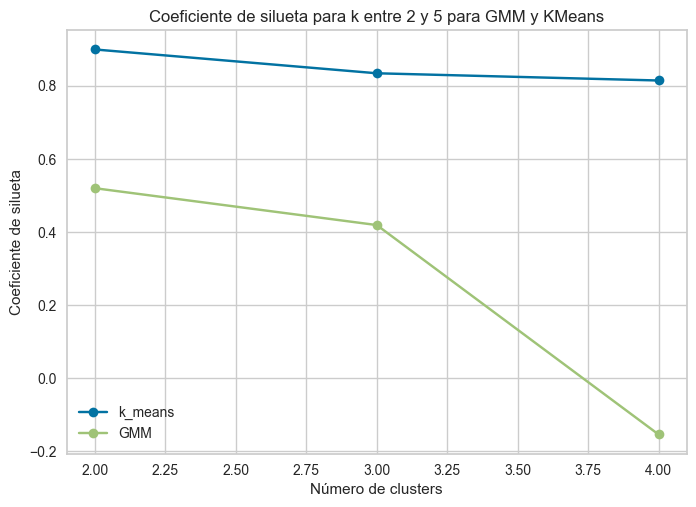

In [91]:
#Silhouette Score - KMeans

#Silhouette data

silueta_kmeans = []
for k in list(range(2,5)):
    model = KMeans(n_clusters=k, init='k-means++', max_iter=50, n_init=10)
    model.fit(data)
    labels = model.fit_predict(data)
    score = silhouette_samples(data, labels)
    score_avg = silhouette_score(data, labels)
    silueta_kmeans.append(score_avg)

plt.plot(range(2,5), silueta_kmeans, 'bo-', label='k_means')

silueta_gmm = []
for k in list(range(2,5)):
    model = GMM(n_components=k, max_iter=100, n_init=10)
    model.fit(data)
    labels = model.fit_predict(data)
    score = silhouette_samples(data, labels)
    score_avg = silhouette_score(data, labels)
    silueta_gmm.append(score_avg)

plt.plot(range(2,5), silueta_gmm, 'go-', label='GMM')

plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente de silueta')
plt.title('Coeficiente de silueta para k entre 2 y 5 para GMM y KMeans')
plt.legend()

N Clusters : 2
Score Silueta : 0.9


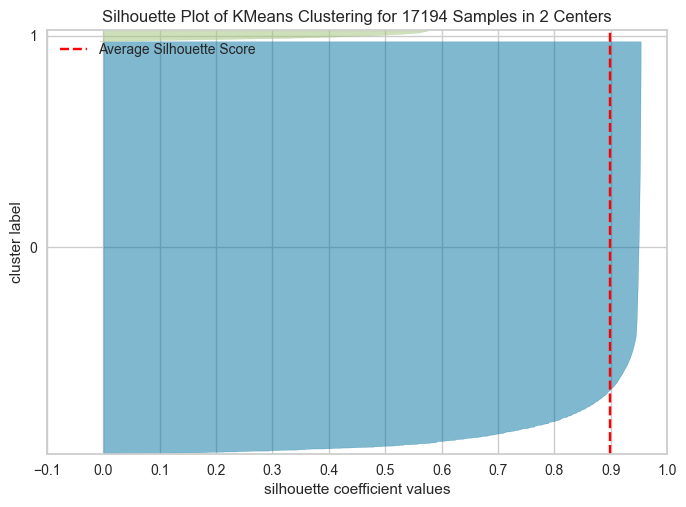

N Clusters : 3
Score Silueta : 0.83


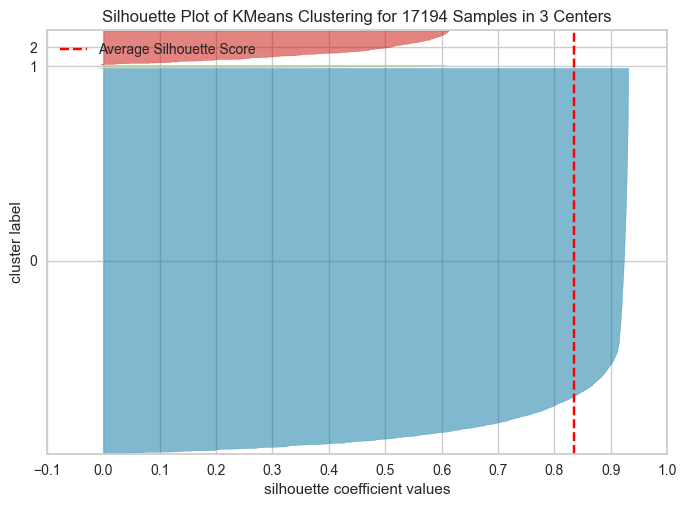

N Clusters : 4
Score Silueta : 0.81


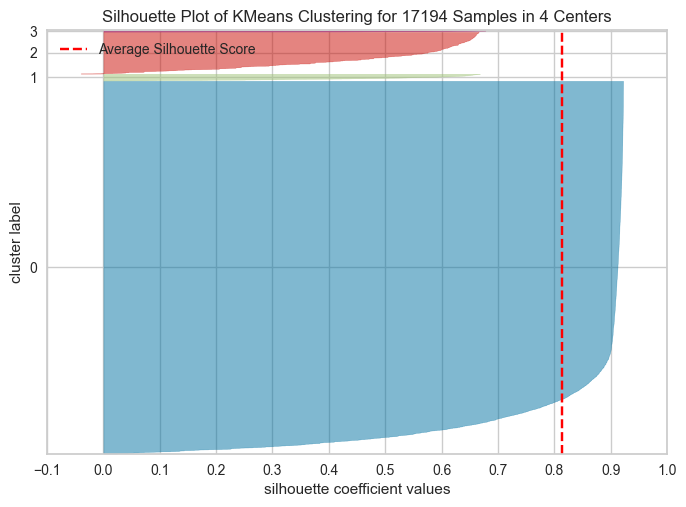

N Clusters : 5
Score Silueta : 0.79


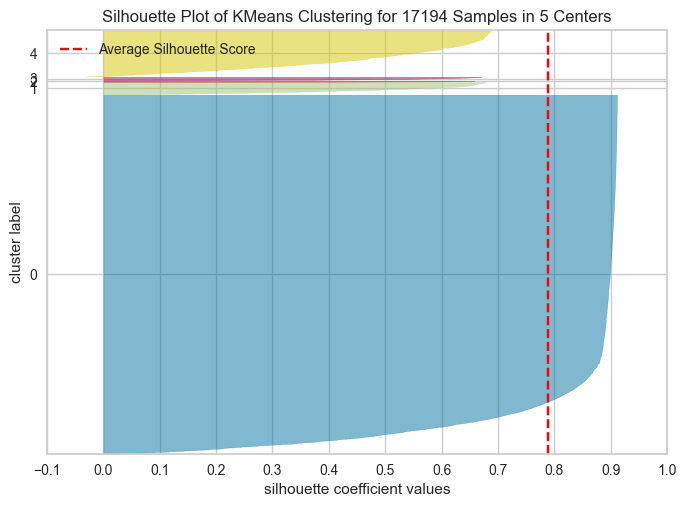

In [94]:
#Silhouette data

for i in range(2,6):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=50, n_init=10)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
    visualizer.fit(data)
    print(f"N Clusters : {i}")
    print(f"Score Silueta : {round(visualizer.silhouette_score_,2)}")
    visualizer.show()

N Clusters : 2
Score Silueta : 0.14


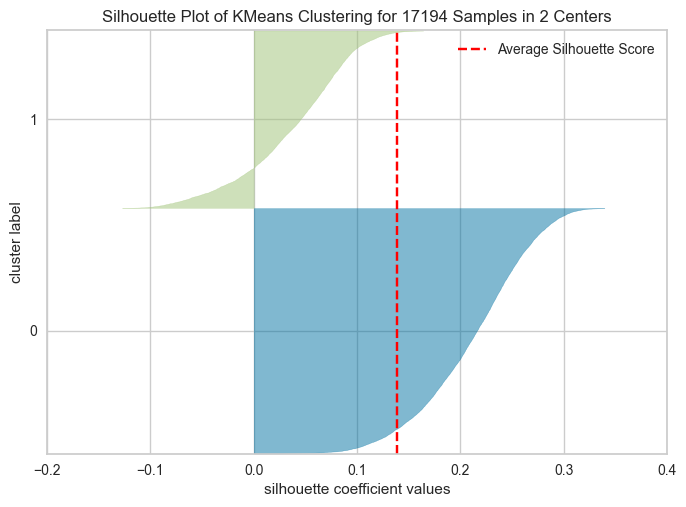

N Clusters : 3
Score Silueta : 0.17


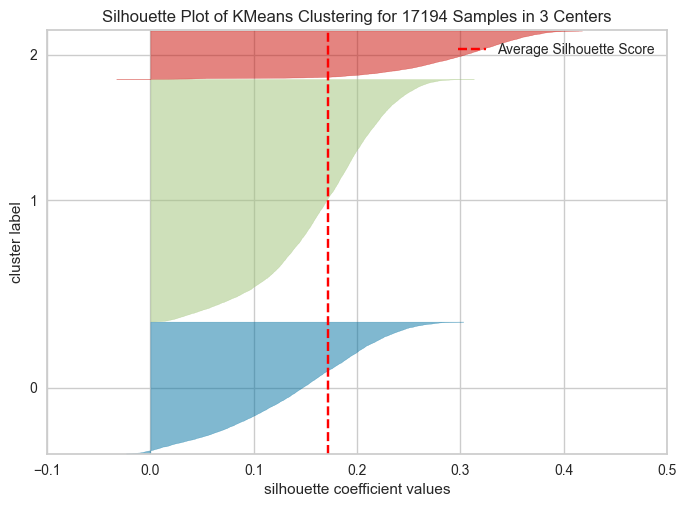

N Clusters : 4
Score Silueta : 0.17


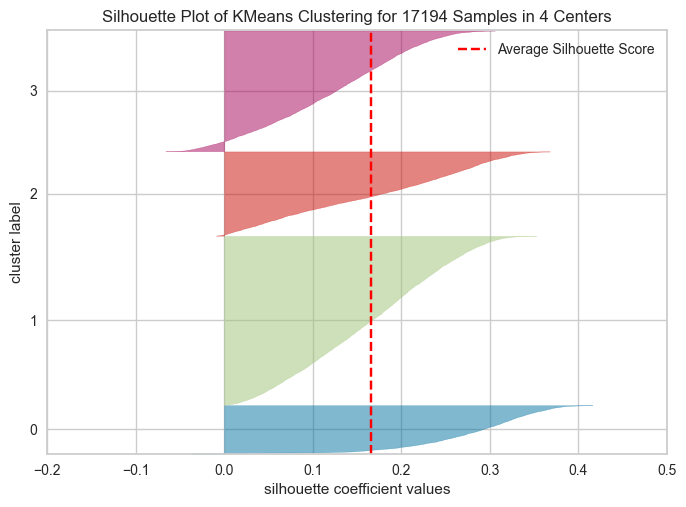

N Clusters : 5
Score Silueta : 0.17


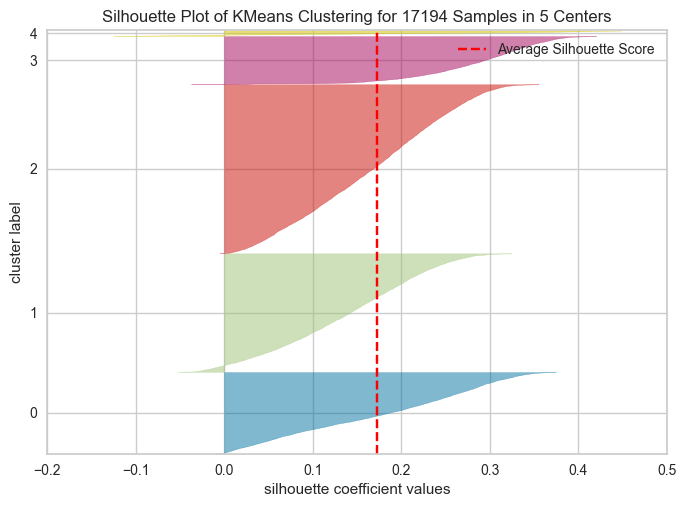

In [95]:
#Silhoutte data2

for i in range(2,6):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=50, n_init=10)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
    visualizer.fit(data2)
    print(f"N Clusters : {i}")
    print(f"Score Silueta : {round(visualizer.silhouette_score_,2)}")
    visualizer.show()

N Clusters : 2
Score Silueta : 0.41


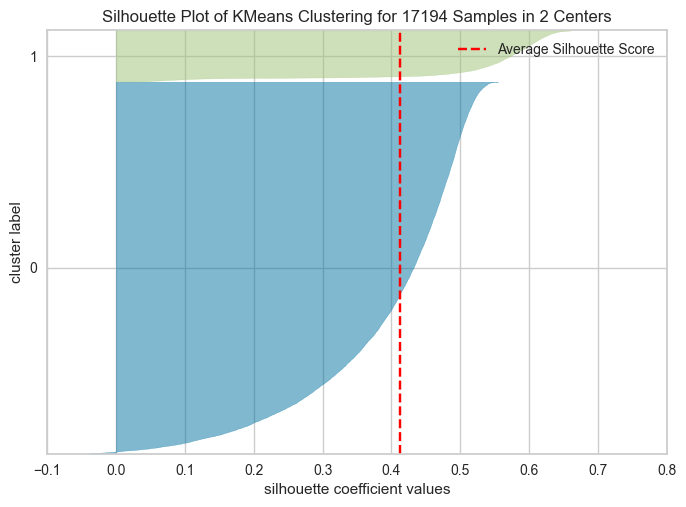

N Clusters : 3
Score Silueta : 0.22


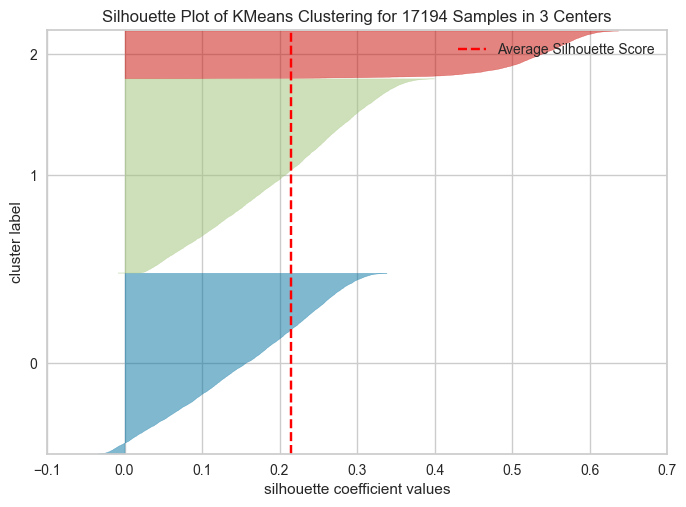

N Clusters : 4
Score Silueta : 0.22


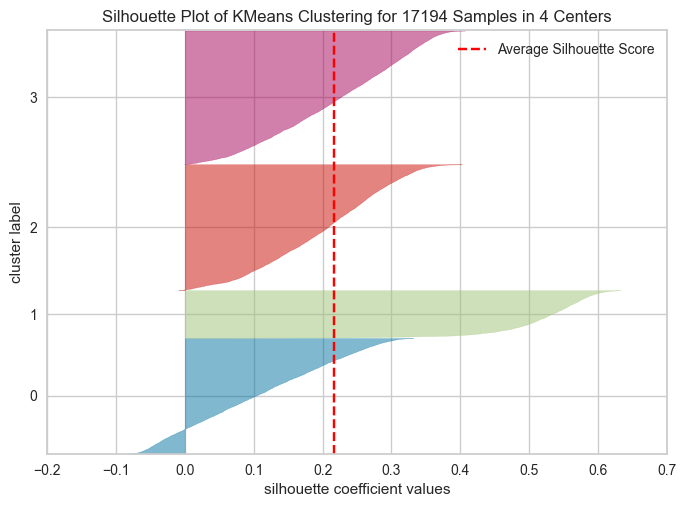

N Clusters : 5
Score Silueta : 0.2


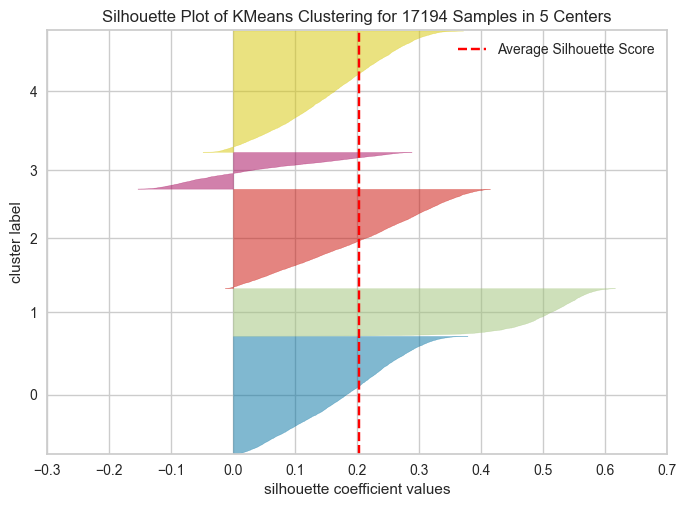

In [96]:
#Silhoutte data3

for i in range(2,6):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=50, n_init=10)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
    visualizer.fit(data3)
    print(f"N Clusters : {i}")
    print(f"Score Silueta : {round(visualizer.silhouette_score_,2)}")
    visualizer.show()

## Modelos

In [97]:
#dataset final = data

#KMeans data

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=50, n_init=10, random_state=0)
kmeans.fit(data)
data['Cluster KM'] = kmeans.labels_

In [99]:
data['Cluster KM'].value_counts()

Cluster KM
0    15688
1     1379
2      127
Name: count, dtype: int64

In [100]:
#KMeans data2

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=50, n_init=10, random_state=0)
kmeans.fit(data2)
data2['Cluster KM'] = kmeans.labels_

data2['Cluster KM'].value_counts()

Cluster KM
0    9866
1    5361
2    1967
Name: count, dtype: int64

In [101]:
#KMeans data3

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=50, n_init=10, random_state=0)
kmeans.fit(data3)
data3['Cluster KM'] = kmeans.labels_

data3['Cluster KM'].value_counts()

Cluster KM
1    7893
0    7362
2    1939
Name: count, dtype: int64

In [105]:
#Scores de siluetas

silhouette_score(data, data['Cluster KM'])

0.8342796710960652

In [106]:
#scores de siluetas data2

silhouette_score(data2, data2['Cluster KM'])

0.20128917429083926

In [108]:
#scores de siluetas data3

silhouette_score(data3, data3['Cluster KM'])

0.22117112989046483

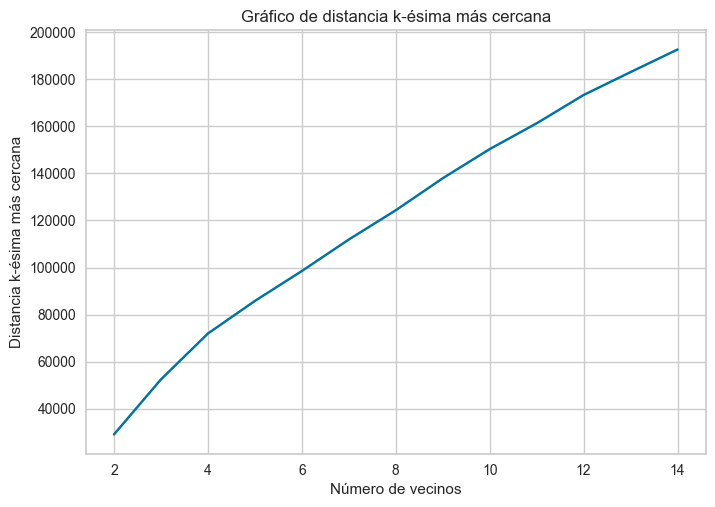

In [103]:
#DBSCAN data

#nummero optimo de vecinos

n_neighbors = range(2, 15)
distances = []
for k in n_neighbors:
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(data.drop('Cluster KM', axis=1))
    distances.append(np.mean(nbrs.kneighbors(data.drop('Cluster KM', axis=1))[0][:, -1]))

plt.plot(n_neighbors, distances)
plt.xlabel('Número de vecinos')
plt.ylabel('Distancia k-ésima más cercana')
plt.title('Gráfico de distancia k-ésima más cercana')
plt.show()

In [104]:
#Numero óptimo de epsilon


from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=9)
nbrs = neigh.fit(data.drop('Cluster KM', axis=1))
distancias,_ = nbrs.kneighbors(data.drop('Cluster KM', axis=1))
distancias = np.sort(distancias, axis=0)
distancias = distancias[:,1]
aux=pd.DataFrame()
aux["distancias"]=sorted(list(distancias),reverse=False)
aux["index"]=range(len(distancias))
fig = px.line(aux, x="index", y="distancias", title="Valor óptimo de Epsilon")
fig.show()

In [109]:
#Gaussian Mixture Model - data

gmm = GMM(n_components=3).fit(data.drop('Cluster KM', axis=1))
labels = gmm.predict(data.drop('Cluster KM', axis=1))
data['Clúster GMM'] = labels

In [110]:
#Scores de siluetas

silhouette_score(data.drop('Cluster KM', axis=1), data['Clúster GMM'])

0.4187687643518755

In [111]:
data = data.drop('Clúster GMM', axis=1)

## Visualizacción de Grupos

In [115]:
dataPCA2['Cluster KM'] = data['Cluster KM']
dataPCA3['Cluster KM'] = data['Cluster KM']

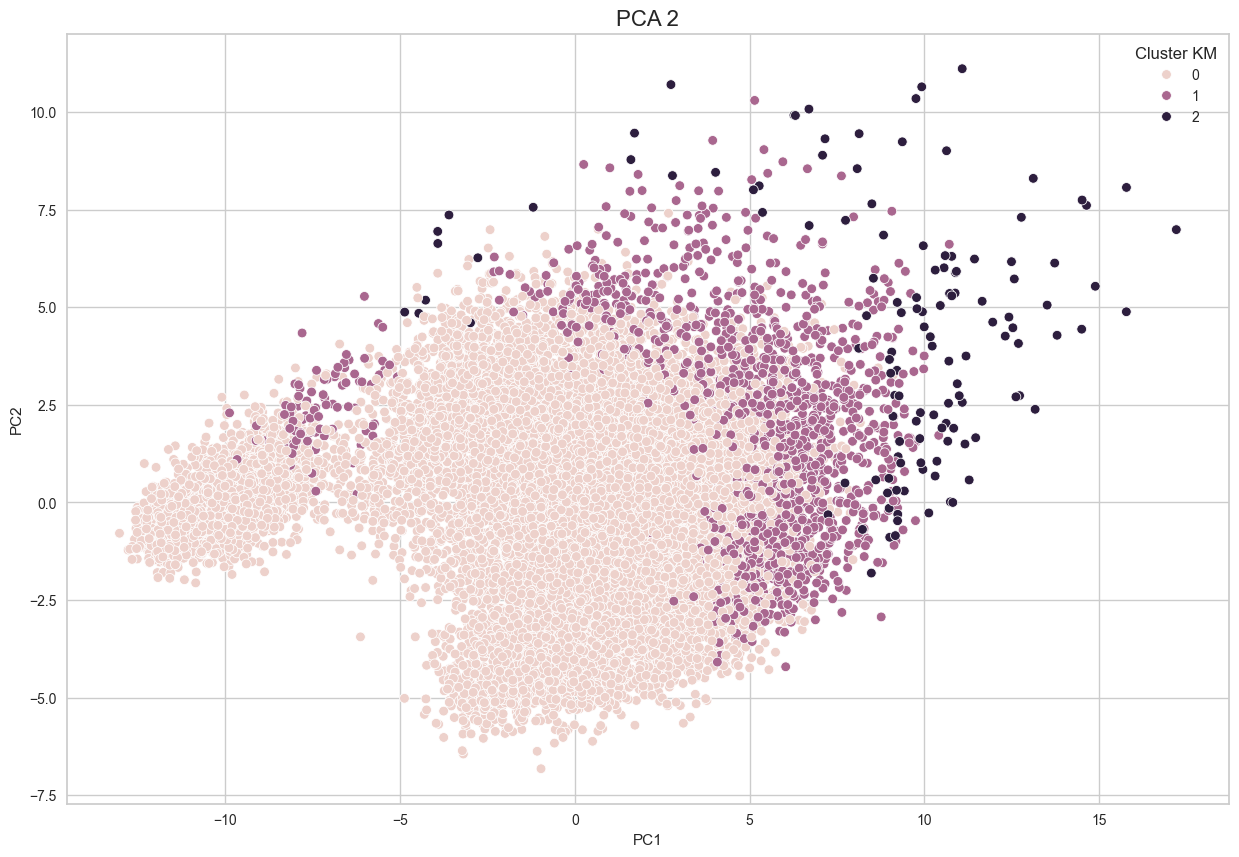

In [116]:
#PCA 2 - Grafica

plt.figure(figsize=(15, 10))
sns.scatterplot(x='PC1', y='PC2', data=dataPCA2, hue='Cluster KM')
plt.title('PCA 2', fontsize=16)
plt.show()

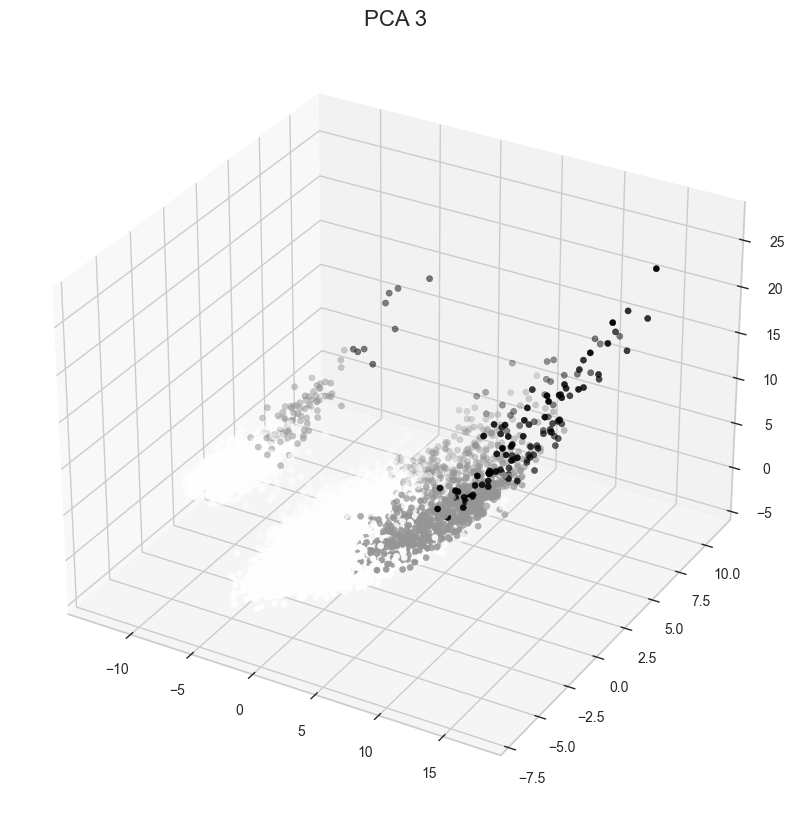

In [117]:
#PCA 3 - Grafica

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataPCA3['PC1'], dataPCA3['PC2'], dataPCA3['PC3'], c=dataPCA3['Cluster KM'])
plt.title('PCA 3', fontsize=16)
plt.show()

In [118]:
#PCA 3 - Plotly

fig = px.scatter_3d(dataPCA3, x='PC1', y='PC2', z='PC3', color='Cluster KM')
fig.show()

## Perfilamiento

In [122]:
data = data.groupby('Cluster KM').median()

In [123]:
dataPCA2['Cluster KM'].value_counts()

Cluster KM
0    15688
1     1379
2      127
Name: count, dtype: int64

In [124]:
data

Age    Overall  Potential         Value           Wage  \
Cluster KM                                                                 
0           25.184982  65.139661  70.265298  1.211032e+06    5911.715961   
1           25.836113  77.777375  80.827411  1.203807e+07   39961.566352   
2           26.196850  85.992126  88.244094  4.787402e+07  160015.748031   

                Special  Preferred Foot  International Reputation  Weak Foot  \
Cluster KM                                                                     
0           1570.705507        0.770525                 21.086181  58.465069   
1           1877.461929        0.766497                 32.777375  64.641044   
2           2036.307087        0.724409                 60.472441  68.818898   

            Skill Moves  Work Rate  Body Type  Position      Height  \
Cluster KM                                                            
0             45.868180  56.866713   1.471252  2.544620  176.770905   
1             60.159536  65.155910   1.509790  2.715736  177.274907   
2             67.244094  68.897638   1.503937  2.881890  177.967200   

               Weight   Crossing  Finishing  HeadingAccuracy  ShortPassing  \
Cluster KM                                                                   
0           75.294161  48.529258  44.205125        51.459842     57.420704   
1           76.275162  62.079043  58.342277        61.125453     71.808557   
2           76.296317  69.094488  67.960630        63.850394     79.401575   

              Volleys  Dribbling      Curve  FKAccuracy  LongPassing  \
Cluster KM                                                             
0           41.625127  53.935811  45.792899   41.753378    51.556795   
1           55.843365  69.200145  60.949239   54.461204    65.182016   
2           65.244094  76.653543  70.393701   64.566929    73.110236   

            BallControl  Acceleration  SprintSpeed    Agility  Reactions  \
Cluster KM                                                                 
0             56.989227     63.770079    63.891318  62.691803  60.611104   
1             72.144307     71.075417    71.311820  70.532995  74.870196   
2             80.204724     76.629921    76.125984  76.811024  84.173228   

              Balance  ShotPower    Jumping    Stamina   Strength  LongShots  \
Cluster KM                                                                     
0           63.411525  54.214304  64.688424  62.303863  65.047170  45.739865   
1           67.812183  68.689630  69.096447  72.199420  69.676577  61.166062   
2           72.488189  74.417323  71.251969  76.929134  70.472441  69.803150   

            Aggression  Interceptions  Positioning     Vision  Penalties  \
Cluster KM                                                                 
0            55.061130      45.938042    48.598865  52.151517  47.560365   
1            65.947788      56.182741    63.075417  66.619289  57.849891   
2            65.244094      56.755906    71.811024  76.070866  65.716535   

            Composure    Marking  StandingTackle  SlidingTackle  \
Cluster KM                                                        
0           57.374809  46.566739       47.034931      45.109192   
1           72.245830  55.720812       56.146483      52.741117   
2           81.488189  57.157480       54.716535      50.740157   

            Release Clause  Duration  Defense Score  Attack Score   GK Score  \
Cluster KM                                                                     
0             1.917504e+06  3.369901      56.658114     58.070277  16.676632   
1             2.313640e+07  5.116751      65.426759     69.515954  15.122408   
2             9.327165e+07  7.188976      68.759843     77.094488  15.702362   

            Continent  
Cluster KM             
0            1.791305  
1            1.564902  
2            1.346457

Clúster 2 - "Jugadores de Elite": Son jugadores que tienen, en general, mejores estadísticas en cuanto a su desempeño en la cancha, tanto en control del balón como su capacidad para ejecutar jugadas de manera efectiva que sean de valor para los puntos del equipo, esto a su vez hace que su valor como jugador, wage y release clause sean hasta 4 veces el valor de los otros clústers, es el clúster con menor número de elementos debido a la dedicación que tienen estos jugadores al momento de trabajar (sus indicadores de hardworking son los más altos). En general los jugadores que pertenecen a este clúster son garantía de buenos resultados ya que están altos en sus valores de desempeño.

También, destaca una gran diferencia respecto a posiciones de ataque para sus equipos, es decir delanteros o medios en posiciones de ataque.

Clúster 1 - "Jugadores buenos elementos": Son jugadores que se encuentran por encima de un valor medio de calificación en cuanto a su desempeño, sin embargo tampoco superan ese valor medio por mucho, su desempeño tiende a ser bueno sin embargo no resulta tal vez tan malo como para mejorar sus estadísticas y por lo tanto, sus estadísticas monetarias y de valor no pueden crecer tanto como los jugadores de élite, el cambio que deben hacer para salir de este grupo representa una gran diferencia en cuanto a sus valores ya que su desempeño es aceptable pero no extraordinario para un equipo.

Las estadísiticas de posicionamiento de éstos está más equilibrada con los de élite en las posiciones defensivas por lo que se puede inferir que éstas son las posiciones que estos jugadores tienden a ocupar como delanteros, medios o defensas.

Clúster 0 - "Novatos": Los jugadores de éste clúster (que a su vez es el que más elementos concentra) se caracterizan por estar, con poca diferencia, por encima o por debajo de las evaluaciones para jugadores profesionales, sus sueldos y estadísticas monetarias son por lo tanto las más bajas del dataset y sus períodos de contratos en clubs también tienden a ser los más bajos o que puede deberse a una constante rotación dada sus estadísticas bajas. Este clúster tienen tambien a los jugadores más jóvenes aunque no por mucho con los otros clústers, es el de lo que tienen las estad´siticas más bajas en cuanto a rendimiento, ejecución y reputación de jugadas.

Sus estadísticas de ataque y defensa tienden a ser las menores sin embargo las más altas en cuanto a GoalKeeper por lo que los porteros también pertencen a este clúster.